In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
df = pd.read_csv('/content/Dataset_final.csv')

Размер датасета: (41800, 5)

Типы данных:
review_id          int64
clause_id          int64
clause            object
llm_topics        object
llm_sentiments    object
dtype: object

Количество пропусков по колонкам:
review_id         0
clause_id         0
clause            0
llm_topics        0
llm_sentiments    0
dtype: int64

Доля пропусков по колонкам (%):
review_id         0.0
clause_id         0.0
clause            0.0
llm_topics        0.0
llm_sentiments    0.0
dtype: float64

=== Распределение для llm_topics ===
llm_topics
[]                                                                                  27.7
["Обслуживание"]                                                                    18.9
["Дистанционное обслуживание"]                                                       6.6
["Кредитная карта"]                                                                  5.7
["Дебетовая карта"]                                                                  5.1
                   

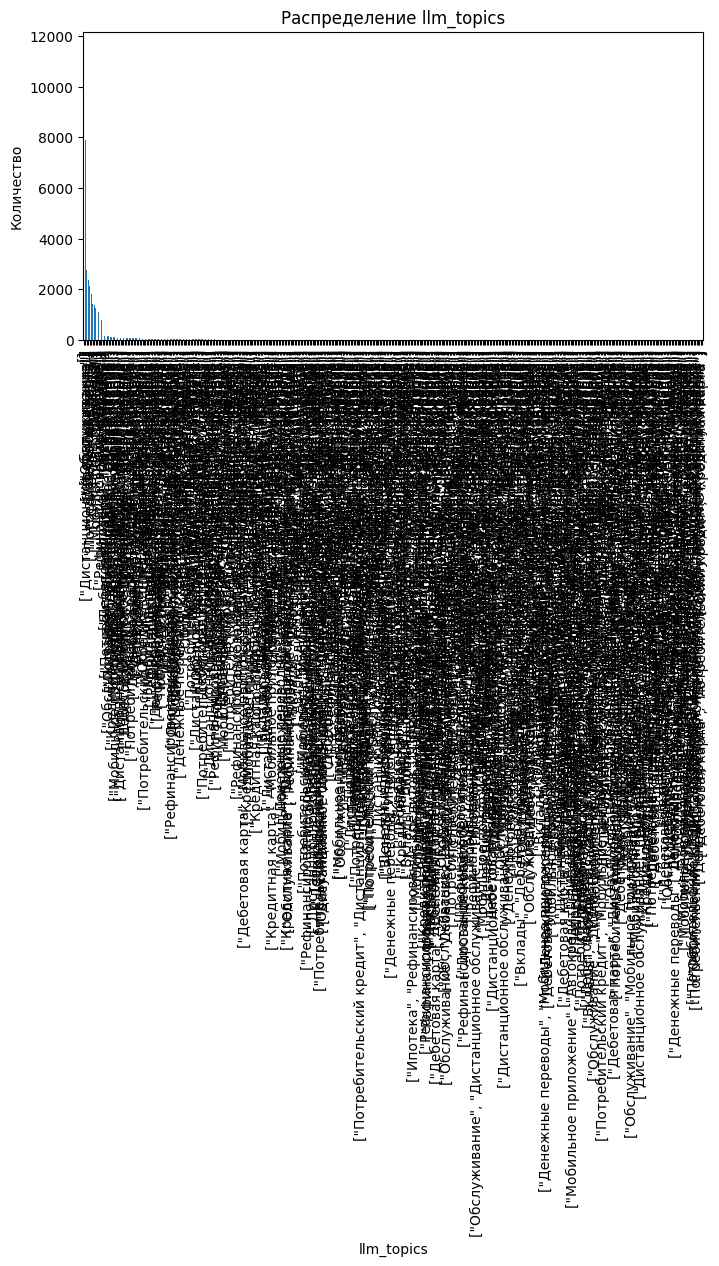


=== Распределение для llm_sentiments ===
llm_sentiments
["отрицательно"]                                                                                  32.6
[]                                                                                                27.7
["нейтрально"]                                                                                    21.2
["положительно"]                                                                                   7.7
["отрицательно", "отрицательно"]                                                                   3.7
["нейтрально", "нейтрально"]                                                                       3.4
["положительно", "положительно"]                                                                   0.9
["нейтрально", "отрицательно"]                                                                     0.7
["отрицательно", "нейтрально"]                                                                     0.5
["нейтрально", "

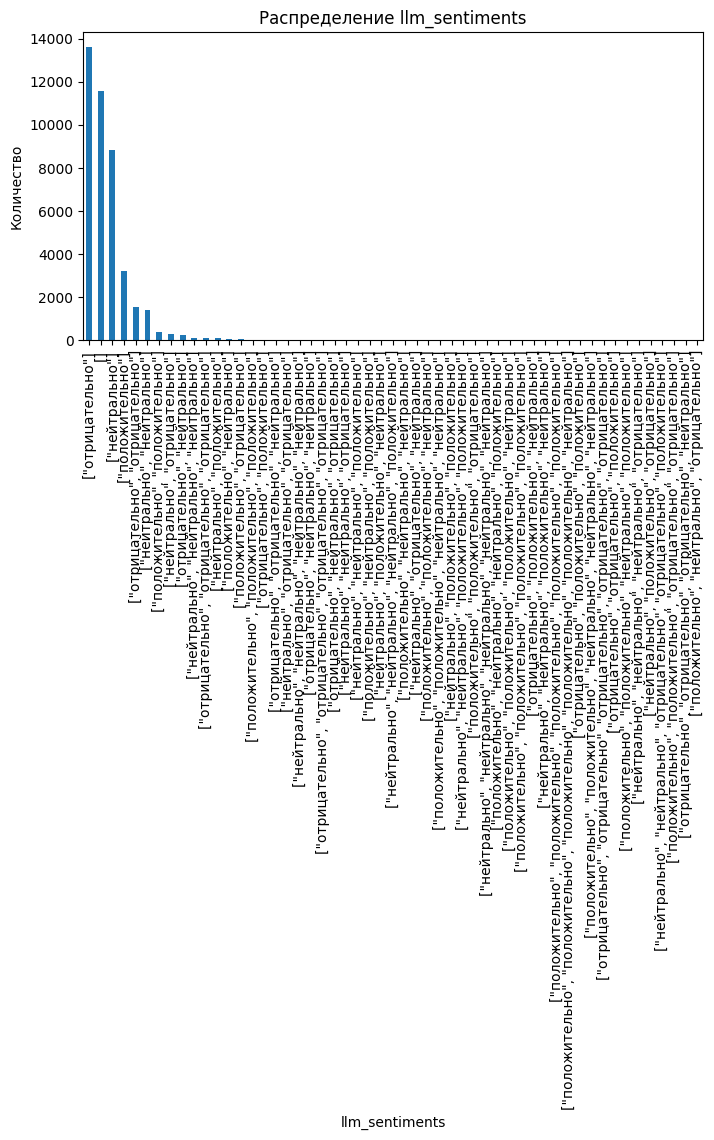

In [ ]:
# Общая информация
print("Размер датасета:", df.shape)
print("\nТипы данных:")
print(df.dtypes)

# Проверка пропусков
print("\nКоличество пропусков по колонкам:")
print(df.isna().sum())

print("\nДоля пропусков по колонкам (%):")
print((df.isna().mean() * 100).round(2))

# Распределение по классам
for col in ["llm_topics", "llm_sentiments"]:
    print(f"\n=== Распределение для {col} ===")
    print(df[col].value_counts(dropna=False, normalize=True).round(3) * 100)

    plt.figure(figsize=(8,4))
    df[col].value_counts(dropna=False).plot(kind="bar")
    plt.title(f"Распределение {col}")
    plt.ylabel("Количество")
    plt.show()


In [ ]:
import ast

# Функция для преобразования строки в список
def parse_list(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

df["llm_topics_list"] = df["llm_topics"].apply(parse_list)
df["llm_sentiments_list"] = df["llm_sentiments"].apply(parse_list)

# Общая доля пустых
for col in ["llm_topics_list", "llm_sentiments_list"]:
    empty_ratio = (df[col].apply(len) == 0).mean() * 100
    print(f"Доля пустых в {col}: {empty_ratio:.2f}%")

# Распределение классов
from collections import Counter

def flatten_counts(series):
    return Counter([item for sublist in series for item in sublist])

topic_counts = flatten_counts(df["llm_topics_list"])
sentiment_counts = flatten_counts(df["llm_sentiments_list"])

print("\nТоп-10 topics:")
print(topic_counts.most_common(10))

print("\nРаспределение sentiments:")
print(sentiment_counts)

# Доля пустых по классам
df["is_empty_topic"] = df["llm_topics_list"].apply(lambda x: len(x)==0)
df["is_empty_sentiment"] = df["llm_sentiments_list"].apply(lambda x: len(x)==0)

print("\nДоля пустых по sentiments для каждого topic:")
topic_empty_stats = (
    df.explode("llm_topics_list")
      .groupby("llm_topics_list")["is_empty_sentiment"]
      .mean()
      .sort_values()
)
print(topic_empty_stats)

# Статистика по тексту
df["clause_len"] = df["clause"].apply(len)
df["clause_word_count"] = df["clause"].apply(lambda x: len(x.split()))

print("\nСтатистика по длинам текстов:")
print(df[["clause_len", "clause_word_count"]].describe())


Доля пустых в llm_topics_list: 27.73%
Доля пустых в llm_sentiments_list: 27.73%

Топ-10 topics:
[('Обслуживание', 9414), ('Дистанционное обслуживание', 3782), ('Дебетовая карта', 3259), ('Кредитная карта', 3147), ('Потребительский кредит', 2547), ('Мобильное приложение', 2095), ('Денежные переводы', 1970), ('Вклады', 1960), ('Ипотека', 1772), ('Страхование', 1625)]

Распределение sentiments:
Counter({'отрицательно': 17756, 'нейтрально': 12976, 'положительно': 4430})

Доля пустых по sentiments для каждого topic:
llm_topics_list
Автокредит                    0.0
Вклады                        0.0
Дебетовая карта               0.0
Денежные переводы             0.0
Дистанционное обслуживание    0.0
Другое                        0.0
Ипотека                       0.0
Кредитная карта               0.0
Мобильное приложение          0.0
Обслуживание                  0.0
Потребительский кредит        0.0
Рефинансирование кредитов     0.0
Страхование                   0.0
Name: is_empty_sentiment,

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-large")
model = AutoModelForMaskedLM.from_pretrained("FacebookAI/xlm-roberta-large")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at FacebookAI/xlm-roberta-large were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model_dir = "xlmr_topics"
os.makedirs(model_dir, exist_ok=True)


In [ ]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification,  get_linear_schedule_with_warmup
from tqdm import tqdm
from torch.optim import AdamW


# -------------------------------
# Dataset
# -------------------------------
class ClauseDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.float)
        }


# -------------------------------
# Metrics
# -------------------------------
def compute_metrics(preds, labels):
    preds = (preds >= 0.5).astype(int)  # thresholding
    precision = precision_score(labels, preds, average="weighted", zero_division=0)
    recall = recall_score(labels, preds, average="weighted", zero_division=0)
    f1 = f1_score(labels, preds, average="weighted", zero_division=0)
    return {"precision": precision, "recall": recall, "f1": f1}


In [ ]:
train_df = pd.read_csv('dataset_train.csv')
test_df = pd.read_csv('dataset_test.csv')

In [ ]:
test_df

,review_id,clause_id,clause,llm_topics,llm_sentiments,llm_topics_parsed
0,3933,0,задача: нужно перевести мои собственные денежн...,"[""Кредитная карта"", ""Денежные переводы""]","[""нейтрально"", ""нейтрально""]","['Кредитная карта', 'Денежные переводы']"
1,4795,1,На время обеда при посещение отделения прождал...,"[""Обслуживание""]","[""отрицательно""]",['Обслуживание']
2,168,10,Я снова обратиасть в контактный центр - ответ ...,"[""Дистанционное обслуживание"", ""Мобильное прил...","[""отрицательно"", ""нейтрально""]","['Дистанционное обслуживание', 'Мобильное прил..."
3,4551,23,то связаться с сотрудниками банка можно будет ...,"[""Обслуживание""]","[""отрицательно""]",['Обслуживание']
4,4233,0,"Являюсь клиентом банка 8, 5 лет (все это время...",[],[],[]
...,...,...,...,...,...,...
10674,3128,25,"чтобы клиент не мог получить ответ, либо те, к...","[""Обслуживание""]","[""отрицательно""]",['Обслуживание']
10675,4703,16,Я решил написать претензию с просьбой разобрат...,[],[],[]
10676,3520,0,"Оформил карту по ссылке, при которой при перво...","[""Другое""]","[""отрицательно""]",['Другое']
10677,84,2,карту на которую якобы придут кредитные деньги...,"[""Дебетовая карта"", ""Потребительский кредит""]","[""отрицательно"", ""отрицательно""]","['Дебетовая карта', 'Потребительский кредит']"


In [ ]:
# -------------------------------
# Script starts here
# -------------------------------
model_dir = "xlmr_topics"
os.makedirs(model_dir, exist_ok=True)

# Подгруженные вами датасеты train_df и test_df
# train_df, test_df уже должны быть pandas DataFrame с колонкой 'clause' и 'llm_topics'

# Очистка текста
train_df["clause"] = train_df["clause"].astype(str).apply(
    lambda x: re.sub(r"\s+", " ", re.sub(r"[^\w\s.,;:!?()-]", " ", x.lower())).strip()
)
test_df["clause"] = test_df["clause"].astype(str).apply(
    lambda x: re.sub(r"\s+", " ", re.sub(r"[^\w\s.,;:!?()-]", " ", x.lower())).strip()
)

# Мульти-лейблы
train_df["llm_topics"] = train_df["llm_topics"].fillna("").apply(lambda x: [t.strip() for t in str(x).split(",") if t.strip()])
test_df["llm_topics"] = test_df["llm_topics"].fillna("").apply(lambda x: [t.strip() for t in str(x).split(",") if t.strip()])

mlb = MultiLabelBinarizer()
Y_train = mlb.fit_transform(train_df["llm_topics"])
Y_test = mlb.transform(test_df["llm_topics"])

# Сохраняем метки для инференса
with open(os.path.join(model_dir, "labels.txt"), "w", encoding="utf-8") as f:
    for label in mlb.classes_:
        f.write(label + "\n")

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['"Автокредит"', '"Вклады"', '"Дебетовая карта"', '"Денежные переводы"', '"Дистанционное обслуживание"', '"Другое"', '"Ипотека"', '"Кредитная карта"', '"Мобильное приложение"', '"Обслуживание"', '"Потребительский кредит"', '"Рефинансирование кредитов"', '"Страхование"'] will be ignored
  warnings.warn(


In [ ]:
# # First split
# train_df, temp_df = train_test_split(
#     df,
#     test_size=0.3,
#     random_state=42,
#     stratify=(Y.sum(axis=1) > 0)   # stratify on original dataset
# )

# # For second split, compute stratify on temp_df
# Y_temp = mlb.transform(temp_df["llm_topics"])
# val_df, test_df = train_test_split(
#     temp_df,
#     test_size=0.5,
#     random_state=42,
#     stratify=(Y_temp.sum(axis=1) > 0)
# )


In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("FacebookAI/xlm-roberta-large")

In [ ]:
train_dataset = ClauseDataset(train_df["clause"].values, Y_train, tokenizer)
test_dataset = ClauseDataset(test_df["clause"].values, Y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "FacebookAI/xlm-roberta-large",
    num_labels=len(mlb.classes_),
    problem_type="multi_label_classification"
).to(device)


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Optimizer & scheduler
num_epochs = 3
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)


In [ ]:
import os, shutil, torch

def save_checkpoint(model, tokenizer, optimizer, scheduler, epoch, best_f1, path, scaler=None):
    os.makedirs(path, exist_ok=True)
    # веса модели/tokenizer в формате HF
    model.save_pretrained(path)
    tokenizer.save_pretrained(path)
    # тренинговое состояние
    state = {
        "epoch": epoch,
        "best_f1": best_f1,
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "scaler": scaler.state_dict() if scaler is not None else None,
        "torch_rng_state": torch.get_rng_state(),
        "cuda_rng_state": torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
    }
    # атомарная запись
    tmp = os.path.join(path, "training_state.tmp")
    torch.save(state, tmp)
    shutil.move(tmp, os.path.join(path, "training_state.pt"))

def load_checkpoint(path, model, tokenizer, optimizer=None, scheduler=None, scaler=None, map_location="cpu"):
    from transformers import AutoConfig, AutoModel
    # если нужно: model/tokenizer = from_pretrained(path)
    # восстановление тренингового состояния:
    state = torch.load(os.path.join(path, "training_state.pt"), map_location=map_location)
    if optimizer: optimizer.load_state_dict(state["optimizer"])
    if scheduler: scheduler.load_state_dict(state["scheduler"])
    if scaler and state.get("scaler"): scaler.load_state_dict(state["scaler"])
    if state.get("torch_rng_state") is not None:
        torch.set_rng_state(state["torch_rng_state"])
    if torch.cuda.is_available() and state.get("cuda_rng_state") is not None:
        for i, s in enumerate(state["cuda_rng_state"]):
            torch.cuda.set_rng_state(s, device=i)
    return state["epoch"], state["best_f1"]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_dir = "/content/drive/MyDrive/colab_checkpoints/my_model"

Mounted at /content/drive


In [ ]:
print(device)
# Обучение
best_f1 = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = (
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device),
            batch["labels"].to(device),
        )
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Оценка на test_df
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = (
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["labels"].to(device),
            )
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()
            test_preds.extend(probs)
            test_labels.extend(labels.cpu().numpy())

    metrics = compute_metrics(np.array(test_preds), np.array(test_labels))
    print(f"Epoch {epoch+1} | Train Loss {total_loss/len(train_loader):.4f} | Test F1 {metrics['f1']:.4f}")

    if metrics["f1"] > best_f1:
        best_f1 = metrics["f1"]
        model.save_pretrained(model_dir)
        tokenizer.save_pretrained(model_dir)
        save_checkpoint(model, tokenizer, optimizer, scheduler, epoch+1, best_f1, path=os.path.join(model_dir, "best"))

    # всегда сохраняем последний чекпоинт (для восстановления после вылета)
    save_checkpoint(model, tokenizer, optimizer, scheduler, epoch+1, best_f1, path=os.path.join(model_dir, "last"))

print(f"Training finished. Best Test F1: {best_f1:.4f}")

cuda


Training epoch 1: 100%|██████████| 3891/3891 [48:25<00:00,  1.34it/s]


Epoch 1 | Train Loss 0.0911 | Test F1 0.0000


Training epoch 2: 100%|██████████| 3891/3891 [48:24<00:00,  1.34it/s]


Epoch 2 | Train Loss 0.0903 | Test F1 0.0000


Training epoch 3: 100%|██████████| 3891/3891 [48:23<00:00,  1.34it/s]


Epoch 3 | Train Loss 0.0901 | Test F1 0.0000
Training finished. Best Test F1: 0.0000


In [ ]:
# Преобразуем вероятности в бинарные предсказания
pred_binary = (np.array(test_preds) >= 0.1).astype(int)

# Восстановим текстовые метки из MultiLabelBinarizer
pred_classes = mlb.inverse_transform(pred_binary)
real_classes = mlb.inverse_transform(np.array(test_labels))

# Собираем в датафрейм
results_df = pd.DataFrame({
    "clause": test_df["clause"].values,
    "predicted_class": [", ".join(p) if p else "NONE" for p in pred_classes],
    "real_class": [", ".join(r) if r else "NONE" for r in real_classes]
})

# Сохраним в csv
#results_df.to_csv(os.path.join(model_dir, "test_results.csv"), index=False, encoding="utf-8")

# Или выведем первые строки
#print(results_df.head(20))


In [ ]:
trai

In [ ]:
probs = np.array(test_preds)  # shape: [N, C
print("Mean prob per class:", probs.mean(axis=0))  # средняя увереность по классам
pred_bin_05 = (probs >= 0.5).astype(int)
print("Predicted positives @0.5:", pred_bin_05.sum(axis=0))  # сколько раз класс вообще предсказался
print("Class frequencies train:", Y_train.sum(axis=0))        # сколько раз встречается в трейнеresults_df

Mean prob per class: [2.5216248e-04 1.2743194e-03 3.9763306e-03 1.7319218e-03 3.4086637e-03
 1.5308744e-03 1.2648533e-03 1.9245503e-03 7.7972319e-03 6.0415789e-03
 1.2569256e-03 4.4347049e-04 4.1811853e-03 1.5279725e-03 1.7070485e-02
 2.3193127e-03 3.3163872e-02 6.4592725e-03 5.1309086e-02 2.0141182e-03
 3.2540701e-02 2.0504002e-03 6.8342470e-02 2.0696793e-04 2.4448093e-02
 2.1322567e-03 3.0017683e-02 2.7851423e-03 5.5975724e-02 5.4255403e-03
 2.6162332e-02 2.3535448e-03 1.8518265e-01 4.2846678e-03 4.4012692e-02
 1.8997310e-03 1.8310614e-02 2.5859158e-03 2.3791518e-02 3.1377786e-01]
Predicted positives @0.5: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Class frequencies train: [  14   53  146   63  133   62   45   66  289  232   46   16  157   58
  595   88 1154  249 1737   74 1151   75 2261   10  875   77 1078  103
 1923  185  909   80 5933  156 1477   73  623   94  810 9273]


,clause,predicted_class,real_class
0,задача: нужно перевести мои собственные денежн...,"[""Обслуживание""], []","""Денежные переводы""], [""Кредитная карта"""
1,на время обеда при посещение отделения прождал...,"[""Обслуживание""], []","[""Обслуживание""]"
2,я снова обратиасть в контактный центр - ответ ...,"[""Обслуживание""], []","""Мобильное приложение""], [""Дистанционное обслу..."
3,то связаться с сотрудниками банка можно будет ...,"[""Обслуживание""], []","[""Обслуживание""]"
4,"являюсь клиентом банка 8, 5 лет (все это время...","[""Обслуживание""], []",[]
...,...,...,...
10674,"чтобы клиент не мог получить ответ, либо те, к...","[""Обслуживание""], []","[""Обслуживание""]"
10675,я решил написать претензию с просьбой разобрат...,"[""Обслуживание""], []",[]
10676,"оформил карту по ссылке, при которой при перво...","[""Обслуживание""], []","[""Другое""]"
10677,карту на которую якобы придут кредитные деньги...,"[""Обслуживание""], []","""Потребительский кредит""], [""Дебетовая карта"""


In [ ]:
test_probs2 = np.array(test_preds)   # shape: (N, C)
test_y2     = np.array(test_labels)  # shape: (N, C), 0/1 floats/ints

# если у тебя есть список имён классов — подставь его сюда:
class_names = [f"class_{i}" for i in range(test_probs2.shape[1])]

In [ ]:
import numpy as np

test_probs2 = np.array(test_preds)   # (N, C)
test_y2     = np.array(test_labels)  # (N, C)

print("test_probs shape:", test_probs2.shape)
print("test_y     shape:", test_y2.shape)
print("num_labels (model):", getattr(model.config, "num_labels", None))

assert test_probs2.shape[1] == len(class_names), \
    f"Число столбцов в предсказаниях ({test_probs2.shape[1]}) != числу лейблов в файле ({len(class_names)})"
assert test_y2.shape[1] == len(class_names), \
    f"Число столбцов в метках ({test_y2.shape[1]}) != числу лейблов ({len(class_names)})"

test_probs shape: (10679, 40)
test_y     shape: (10679, 40)
num_labels (model): 40


In [ ]:
import numpy as np

threshold = 0.5  # можно подобрать оптимальный на валидации
test_probs2 = np.array(test_preds)   # (N, C)
test_y2     = np.array(test_labels)  # (N, C)
test_pred2  = (test_probs2 >= threshold).astype(int)

In [ ]:
with open("xlmr_topics/labels.txt", "r", encoding="utf-8") as f:
    class_names = [line.strip() for line in f if line.strip()]

In [ ]:
for i in range(5):
    true_idx = np.where(test_y2[i] == 1)[0]      # индексы истинных классов
    pred_idx = np.where(test_pred2[i] == 1)[0]   # индексы предсказанных классов

    print(f"\nSample {i}")
    print("  TRUE:", [class_names[j] for j in true_idx])
    print("  PRED:", [class_names[j] for j in pred_idx])
    print("  PROBS:", {class_names[j]: round(test_probs2[i, j], 3) for j in pred_idx})


Sample 0
  TRUE: ['"Денежные переводы"]', '["Кредитная карта"']
  PRED: []
  PROBS: {}

Sample 1
  TRUE: ['["Обслуживание"]']
  PRED: []
  PROBS: {}

Sample 2
  TRUE: ['"Мобильное приложение"]', '["Дистанционное обслуживание"']
  PRED: []
  PROBS: {}

Sample 3
  TRUE: ['["Обслуживание"]']
  PRED: []
  PROBS: {}

Sample 4
  TRUE: ['[]']
  PRED: []
  PROBS: {}


In [ ]:
probs2 = torch.softmax(outputs.logits, dim=-1).cpu().numpy()
pred_classes2 = np.argmax(probs2, axis=1)

In [ ]:
from google.colab import drive
import shutil

# Монтируем Google Drive
drive.mount('/content/drive')

# Путь на Drive
drive_path = '/content/drive/MyDrive/xlmr_topics_saved/'

# Сохраняем модель и токенизатор
model.save_pretrained(drive_path)
tokenizer.save_pretrained(drive_path)

print(f"Модель сохранена на Google Drive: {drive_path}")


In [ ]:
df['llm_topics_tuple'] = df['llm_topics'].apply(tuple)
unique_topics = df['llm_topics_tuple'].unique()
print("Уникальные комбинации тем:", unique_topics)

Уникальные комбинации тем: [('["Обслуживание"]',) ('["Дистанционное обслуживание"]',)
 ('["Мобильное приложение"]',)]


#INFERENCE

In [ ]:
df = df_copy.tail(10)

In [ ]:

MODEL_DIR = "xlmr_topics"
LABELS_FILE = MODEL_DIR + "/labels.txt"
# Load labels
with open(LABELS_FILE, "r", encoding="utf-8") as f:
    labels = [line.strip() for line in f.readlines()]

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

ImportError: You need to install sacremoses to use XLMTokenizer. See https://pypi.org/project/sacremoses/ for installation.

In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

# Paths
MODEL_DIR = "xlmr_topics"
LABELS_FILE = MODEL_DIR + "/labels.txt"

# Load labels
with open(LABELS_FILE, "r", encoding="utf-8") as f:
    labels = [line.strip() for line in f.readlines()]

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Example DataFrame
# df2 = pd.read_csv("your_file.csv")  # has column 'clause'
clauses = df['clause'].astype(str).tolist()

# Tokenize all clauses in batch
batch_size = 16
all_predictions = []

for i in range(0, len(clauses), batch_size):
    batch_clauses = clauses[i:i+batch_size]
    encodings = tokenizer(
        batch_clauses,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**encodings)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()

    # Threshold 0.5 for multi-label
    for prob in probs:
        indices = np.where(prob >= 0.5)[0]
        preds = [labels[idx] for idx in indices]
        all_predictions.append(preds)

# Add predictions to DataFrame
df['predicted_topics'] = all_predictions

# Optional: save
# df2.to_csv("df2_with_predictions.csv", index=False)

print(df[['clause', 'predicted_topics']].head())


                                                  clause  \
4871   пришла в филиал по адресу г новосибирск ул вок...   
4759   15 ноября я позвонила на горячую линию газпром...   
28315  в мобильном приложении нет возможности самому ...   
29628    со мной никто даже и не собирается связываться.   
9936   сотрудники не грамотные специалисты, информаци...   

                                        predicted_topics  
4871   [["Дистанционное обслуживание"], ["Обслуживани...  
4759   [["Дистанционное обслуживание"], ["Обслуживани...  
28315  [["Дистанционное обслуживание"], ["Обслуживани...  
29628  [["Дистанционное обслуживание"], ["Обслуживани...  
9936   [["Дистанционное обслуживание"], ["Обслуживани...  


In [ ]:
df[['clause', 'predicted_topics']]

,clause,predicted_topics
4871,пришла в филиал по адресу г новосибирск ул вок...,"[[""Дистанционное обслуживание""], [""Обслуживани..."
4759,15 ноября я позвонила на горячую линию газпром...,"[[""Дистанционное обслуживание""], [""Обслуживани..."
28315,в мобильном приложении нет возможности самому ...,"[[""Дистанционное обслуживание""], [""Обслуживани..."
29628,со мной никто даже и не собирается связываться.,"[[""Дистанционное обслуживание""], [""Обслуживани..."
9936,"сотрудники не грамотные специалисты, информаци...","[[""Дистанционное обслуживание""], [""Обслуживани..."
4750,"скриншот из моб приложения банка, где в анкете...","[[""Дистанционное обслуживание""], [""Обслуживани..."
30189,"разумеется я затребовал отчеты, по результатам...","[[""Дистанционное обслуживание""], [""Обслуживани..."
36889,сотрудник янина в разговоре вела себя не корее...,"[[""Дистанционное обслуживание""], [""Обслуживани..."
253,"с учетом как у нас работает почта, и затягиван...","[[""Дистанционное обслуживание""], [""Обслуживани..."
38865,"вместо ответа пришла отписка в смс, что необхо...","[[""Дистанционное обслуживание""], [""Обслуживани..."


In [ ]:
df_copy

,review_id,clause_id,clause,llm_topics,llm_sentiments
0,1,0,они сразу не могли пакет документов проверить?,[],[]
1,1,1,неделю общались по электронке три раза застави...,"[""Страхование""]","[""отрицательно""]"
2,1,2,"Вместо обещанных 15 мин просидела 2, 5 ч, у ме...",[],[]
3,1,3,"Наступила завтра вечер– звонят, анкета не та, ...",[],[]
4,1,4,уних она распечатывается с сайта таким же обра...,[],[]
...,...,...,...,...,...
41795,4798,1,Платёж по действующему кредиту составляет 2240...,"[""Рефинансирование кредитов"", ""Страхование""]","[""нейтрально"", ""отрицательно""]"
41796,4798,2,сейчас я тоже ей (финансовой защитой) не польз...,"[""Страхование""]","[""нейтрально""]"
41797,4798,3,"Сейчас по действующему кредиту 13,9 без всяких...","[""Рефинансирование кредитов"", ""Страхование""]","[""положительно"", ""отрицательно""]"
41798,4798,4,"Уважаемый банк, в ваших силах предложить конку...",[],[]


# Никита

In [ ]:
# -*- coding: utf-8 -*-
import os
import re
import ast
import shutil
import random
import numpy as np
import pandas as pd
from dataclasses import dataclass

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm

In [ ]:
# =========================
# Config
# =========================
MODEL_NAME = "FacebookAI/xlm-roberta-large"
MODEL_DIR  = "xlmr_topics"          # куда сохранять лучшую/последнюю версию
MAX_LEN    = 128
BATCH_SIZE = 8
EPOCHS     = 3
LR         = 2e-5
WARMUP_STEPS = 0
USE_AMP    = True                   # смешанная точность
THRESHOLD  = 0.5                    # порог для мультилейбл предсказаний
SEED       = 42

# Быстрый прогон на первых N строках (поставь None чтобы отключить)
N_SAMPLES_TRAIN = None
N_SAMPLES_TEST  = None

CLASSES = [
    "Дебетовая карта",
    "Кредитная карта",
    "Дистанционное обслуживание",
    "Другое",
    "Денежные переводы",
    "Потребительский кредит",
    "Ипотека",
    "Автокредит",
    "Рефинансирование кредитов",
    "Вклады",
    "Мобильное приложение",
    "Обслуживание",
    "Страхование",
]


SyntaxError: invalid syntax (ipython-input-2266368589.py, line 17)

In [ ]:
# =========================
# Utils
# =========================
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def clean_text(x: str) -> str:
    x = str(x).lower()
    x = re.sub(r"[^\w\s.,;:!?()\-]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

def parse_llm_topics(value):
    """
    Ожидаем в колонке строку вида "['Кредитная карта', 'Денежные переводы']".
    Если там уже list — вернём как есть.
    Если NaN/пусто — вернём пустой список.
    """
    if isinstance(value, list):
        return [str(t).strip() for t in value if str(t).strip()]
    if pd.isna(value):
        return []
    s = str(value).strip()
    if not s:
        return []
    try:
        parsed = ast.literal_eval(s)
        if isinstance(parsed, (list, tuple)):
            return [str(t).strip() for t in parsed if str(t).strip()]
    except Exception:
        # fallback: CSV с "a, b, c"
        return [t.strip() for t in s.split(",") if t.strip()]
    return []

In [ ]:
@dataclass
class Batch:
    input_ids: torch.Tensor
    attention_mask: torch.Tensor
    labels: torch.Tensor | None = None

In [ ]:
# =========================
# Dataset
# =========================
class ClauseDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len: int = 128):
        self.texts = list(texts)
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i: int):
        text = str(self.texts[i])
        enc = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
        }
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[i], dtype=torch.float)
        return item


In [ ]:
# =========================
# Metrics
# =========================
def compute_metrics(probs: np.ndarray, y_true: np.ndarray, threshold: float = 0.5):
    y_pred = (probs >= threshold).astype(int)
    return {
        "precision_micro": precision_score(y_true, y_pred, average="micro", zero_division=0),
        "recall_micro":    recall_score( y_true, y_pred, average="micro", zero_division=0),
        "f1_micro":        f1_score(     y_true, y_pred, average="micro", zero_division=0),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro":    recall_score( y_true, y_pred, average="macro", zero_division=0),
        "f1_macro":        f1_score(     y_true, y_pred, average="macro", zero_division=0),
        "precision_weighted": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "recall_weighted":    recall_score( y_true, y_pred, average="weighted", zero_division=0),
        "f1_weighted":        f1_score(     y_true, y_pred, average="weighted", zero_division=0),
    }


In [ ]:
# =========================
# Main
# =========================
def main():
    set_seed(SEED)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    os.makedirs(MODEL_DIR, exist_ok=True)

    # ---- Load data
    train_df = pd.read_csv("dataset_train.csv")
    test_df  = pd.read_csv("dataset_test.csv")

    if N_SAMPLES_TRAIN is not None:
        train_df = train_df.head(N_SAMPLES_TRAIN)
    if N_SAMPLES_TEST is not None:
        test_df  = test_df.head(N_SAMPLES_TEST)

    # ---- Sanity columns
    assert "clause" in train_df.columns, "dataset_train.csv должен содержать колонку 'clause'"
    assert "clause" in test_df.columns,  "dataset_test.csv должен содержать колонку 'clause'"
    assert "llm_topics_parsed" in train_df.columns, "Нужна колонка 'llm_topics_parsed' в train"
    assert "llm_topics_parsed" in test_df.columns,  "Нужна колонка 'llm_topics_parsed' в test"

    # ---- Clean text
    train_df["clause"] = train_df["clause"].astype(str).apply(clean_text)
    test_df["clause"]  = test_df["clause"].astype(str).apply(clean_text)

    # ---- Parse labels
    train_df["topics_list"] = train_df["llm_topics_parsed"].apply(parse_llm_topics)
    test_df["topics_list"]  = test_df["llm_topics_parsed"].apply(parse_llm_topics)

    # ---- Binarizer with fixed order of CLASSES
    mlb = MultiLabelBinarizer(classes=CLASSES)
    Y_train = mlb.fit_transform(train_df["topics_list"])  # fit() не меняет порядок, т.к. classes задан
    Y_test  = mlb.transform(test_df["topics_list"])

    # ---- Persist classes for inference
    with open(os.path.join(MODEL_DIR, "labels.txt"), "w", encoding="utf-8") as f:
        for label in mlb.classes_:
            f.write(label + "\n")

    # ---- Tokenizer & Datasets
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
    train_ds  = ClauseDataset(train_df["clause"].tolist(), Y_train, tokenizer, max_len=MAX_LEN)
    test_ds   = ClauseDataset(test_df["clause"].tolist(),  Y_test,  tokenizer, max_len=MAX_LEN)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # ---- Model
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=len(CLASSES),
        problem_type="multi_label_classification",  # включает BCEWithLogitsLoss
    ).to(device)

    # ---- Optim & Scheduler
    optimizer = AdamW(model.parameters(), lr=LR)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps)

    scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

    # ---- Train loop
    best_f1 = 0.0
    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]")
        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=USE_AMP):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss / (pbar.n + 1))

        # ---- Eval
        model.eval()
        all_probs = []
        all_true  = []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"Epoch {epoch}/{EPOCHS} [eval]"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].cpu().numpy()

                logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
                probs = torch.sigmoid(logits).cpu().numpy()

                all_probs.append(probs)
                all_true.append(labels)

        all_probs = np.vstack(all_probs) if len(all_probs) else np.empty((0, len(CLASSES)))
        all_true  = np.vstack(all_true)  if len(all_true)  else np.empty((0, len(CLASSES)))

        metrics = compute_metrics(all_probs, all_true, threshold=THRESHOLD)
        print(f"Epoch {epoch}: "
              f"loss={running_loss/len(train_loader):.4f} | "
              f"F1_micro={metrics['f1_micro']:.4f} | "
              f"F1_macro={metrics['f1_macro']:.4f} | "
              f"F1_weighted={metrics['f1_weighted']:.4f}")

        # ---- Save best by F1_micro
        if metrics["f1_micro"] > best_f1:
            best_f1 = metrics["f1_micro"]
            # сохранить в корень + best/
            model.save_pretrained(MODEL_DIR)
            tokenizer.save_pretrained(MODEL_DIR)
            #save_checkpoint(model, tokenizer, optimizer, scheduler, epoch, best_f1, path=os.path.join(MODEL_DIR, "best"), scaler=scaler)

        # всегда последний чекпойнт
        #save_checkpoint(model, tokenizer, optimizer, scheduler, epoch, best_f1, path=os.path.join(MODEL_DIR, "last"), scaler=scaler)

    print(f"Training done. Best F1_micro: {best_f1:.4f}")


main()

Device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2999134309.py:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
Epoch 1/3 [train]:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipython-input-2999134309.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 1/3 [eval]: 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]


Epoch 1: loss=0.6385 | F1_micro=0.0638 | F1_macro=0.0217 | F1_weighted=0.0211


Epoch 2/3 [train]:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipython-input-2999134309.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 2/3 [eval]: 100%|██████████| 3/3 [00:00<00:00,  6.38it/s]


Epoch 2: loss=0.6156 | F1_micro=0.0541 | F1_macro=0.0162 | F1_weighted=0.0146


Epoch 3/3 [train]:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipython-input-2999134309.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=USE_AMP):
Epoch 3/3 [eval]: 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]


Epoch 3: loss=0.6094 | F1_micro=0.0580 | F1_macro=0.0171 | F1_weighted=0.0155
Training done. Best F1_micro: 0.0638


In [ ]:
#валидация

# --- Просмотр предсказаний: clause — pred — true — probs ---
import os, ast, json
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_DIR   = "xlmr_topics"
CLASSES = [
    "Дебетовая карта","Кредитная карта","Дистанционное обслуживание","Другое","Денежные переводы",
    "Потребительский кредит","Ипотека","Автокредит","Рефинансирование кредитов","Вклады",
    "Мобильное приложение","Обслуживание","Страхование",
]
MAX_LEN    = 128
BATCH_SIZE = 8
THRESHOLD  = 0.5

def clean_text(x: str) -> str:
    import re
    x = str(x).lower()
    x = re.sub(r"[^\w\s.,;:!?()\-]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

def parse_llm_topics(v):
    if isinstance(v, list): return [str(t).strip() for t in v if str(t).strip()]
    if pd.isna(v): return []
    s = str(v).strip()
    if not s: return []
    try:
        import ast
        obj = ast.literal_eval(s)
        if isinstance(obj, (list, tuple)):
            return [str(t).strip() for t in obj if str(t).strip()]
    except Exception:
        pass
    return [t.strip() for t in s.split(",") if t.strip()]

# --- Загружаем данные: test.csv если есть, иначе 20 строк из train.csv
if os.path.exists("dataset_test.csv"):
    df = pd.read_csv("dataset_test.csv")
else:
    df = pd.read_csv("dataset_train.csv")

df["clause"] = df["clause"].astype(str).apply(clean_text)
src_col = "llm_topics_parsed" if "llm_topics_parsed" in df.columns else "llm_topics"
df["topics_list"] = df[src_col].apply(parse_llm_topics)

# --- Загружаем модель
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(device)
model.eval()

# --- Прогон
texts = df["clause"].tolist()
probs_all = []
with torch.no_grad(), torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
    for i in range(0, len(texts), BATCH_SIZE):
        enc = tokenizer(
            texts[i:i+BATCH_SIZE],
            padding=True, truncation=True, max_length=MAX_LEN,
            return_tensors="pt"
        ).to(device)
        logits = model(**enc).logits
        probs = torch.sigmoid(logits).cpu().numpy()
        probs_all.append(probs)

probs_all = np.vstack(probs_all)
pred_bin = (probs_all >= THRESHOLD).astype(int)

# --- В человекочитаемую таблицу
pred_lists = [[CLASSES[j] for j,v in enumerate(row) if v==1] for row in pred_bin]
true_lists = df["topics_list"].tolist()

rows = []
for i, text in enumerate(texts):
    rows.append({
        "clause": text,
        "pred": ", ".join(pred_lists[i]) if pred_lists[i] else "—",
        "true": ", ".join(true_lists[i]) if true_lists[i] else "—",
        "probs": json.dumps({CLASSES[j]: float(probs_all[i][j]) for j in range(len(CLASSES))}, ensure_ascii=False)
    })

view_df = pd.DataFrame(rows)

# --- Показать первые строки и сохранить полный CSV
print(view_df.head(10).to_string(index=False))
out_path = "predictions_with_probs.csv"
view_df.to_csv(out_path, index=False)
print(f"\nСохранил: {out_path}")


                                                                                                                                                                     clause                                                          pred                                             true                                                                                                                                                                                                                                                                                                                                                                                                                                                        probs
                                                                                             задача: нужно перевести мои собственные денежные средства с кредитной карты. . Потребительский кредит, Ипотека, Вклады, Мобильное приложение               Кредитная карта, Денежны

In [ ]:
view_df

,clause,pred,true,probs
0,задача: нужно перевести мои собственные денежн...,"Потребительский кредит, Ипотека, Вклады, Мобил...","Кредитная карта, Денежные переводы","{""Дебетовая карта"": 0.43505859375, ""Кредитная ..."
1,на время обеда при посещение отделения прождал...,"Потребительский кредит, Ипотека, Вклады, Мобил...",Обслуживание,"{""Дебетовая карта"": 0.43505859375, ""Кредитная ..."
2,я снова обратиасть в контактный центр - ответ ...,"Потребительский кредит, Ипотека, Вклады, Мобил...","Дистанционное обслуживание, Мобильное приложение","{""Дебетовая карта"": 0.432373046875, ""Кредитная..."
3,то связаться с сотрудниками банка можно будет ...,"Потребительский кредит, Ипотека, Вклады, Мобил...",Обслуживание,"{""Дебетовая карта"": 0.437255859375, ""Кредитная..."
4,"являюсь клиентом банка 8, 5 лет (все это время...","Мобильное приложение, Обслуживание",—,"{""Дебетовая карта"": 0.40625, ""Кредитная карта""..."
5,"карта была доставлена вовремя и без задержек, ...","Потребительский кредит, Вклады, Мобильное прил...","Дебетовая карта, Обслуживание","{""Дебетовая карта"": 0.428955078125, ""Кредитная..."
6,проблему в приложении за столько времени (и на...,"Потребительский кредит, Ипотека, Вклады, Мобил...","Мобильное приложение, Рефинансирование кредитов","{""Дебетовая карта"": 0.439697265625, ""Кредитная..."
7,"почему тиньков, альфа банк и другие нормальные...","Потребительский кредит, Ипотека, Вклады, Мобил...",Другое,"{""Дебетовая карта"": 0.434326171875, ""Кредитная..."
8,тк карта была оформлена в рамках акции,"Потребительский кредит, Ипотека, Вклады, Мобил...",Дебетовая карта,"{""Дебетовая карта"": 0.435302734375, ""Кредитная..."
9,сначала несколько дней просто тишины и игнора,"Потребительский кредит, Ипотека, Вклады, Мобил...",Обслуживание,"{""Дебетовая карта"": 0.438720703125, ""Кредитная..."


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
all_probs

NameError: name 'all_probs' is not defined

In [ ]:
import json
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import MultiLabelBinarizer

THRESHOLD = 0.50  # при желании подвинь
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) подготовим бинаризатор на фиксированном порядке классов
mlb = MultiLabelBinarizer(classes=CLASSES)
true_bin = mlb.fit_transform(test_df["topics_list"])

# 3) прогоним тестовые тексты
texts = test_df["clause"].tolist()
probs_all = []
with torch.no_grad(), torch.amp.autocast('cuda', enabled=(DEVICE.type=='cuda')):
    for i in range(0, len(texts), BATCH_SIZE):
        enc = tokenizer(
            texts[i:i+BATCH_SIZE],
            padding=True, truncation=True, max_length=MAX_LEN,
            return_tensors="pt"
        ).to(DEVICE)
        logits = model(**enc).logits
        probs = torch.sigmoid(logits).cpu().numpy()
        probs_all.append(probs)

probs_all = np.vstack(probs_all)
pred_bin = (probs_all >= THRESHOLD).astype(int)

# 4) переводим в человекочитаемый вид
true_lists = test_df["topics_list"].tolist()
pred_lists = [[CLASSES[j] for j, v in enumerate(row) if v==1] for row in pred_bin]

# 5) собираем таблицу
view_rows = []
for i, text in enumerate(texts):
    view_rows.append({
        "clause": text,
        "pred": ", ".join(pred_lists[i]) if pred_lists[i] else "—",
        "true": ", ".join(true_lists[i]) if true_lists[i] else "—",
    })
view_df = pd.DataFrame(view_rows)

# 6) показываем первые строки и сохраняем полный CSV
print(view_df.head(10).to_string(index=False))
view_df.to_csv("predictions_test.csv", index=False)
print("\nСохранил: predictions_test.csv")

In [ ]:
import json

THRESHOLD = 0.50  # можешь подвинуть; ниже есть автоподбор

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# прогон по всему test_df, который ты уже собрал выше
texts = test_df["clause"].tolist()
true_lists = test_df["topics_list"].tolist()

all_probs = []
with torch.no_grad(), torch.amp.autocast('cuda', enabled=USE_AMP and device.type=='cuda'):
    for start in range(0, len(texts), BATCH_SIZE):
        batch_texts = texts[start:start+BATCH_SIZE]
        enc = tokenizer(
            batch_texts,
            padding=True, truncation=True, max_length=MAX_LEN,
            return_tensors="pt"
        ).to(device)
        logits = model(**enc).logits
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)

all_probs = np.vstack(all_probs) if all_probs else np.zeros((0, len(CLASSES)))

# бинаризация по порогу и декодирование в имена классов
bin_preds = (all_probs >= THRESHOLD).astype(int)
pred_lists = [[CLASSES[i] for i, v in enumerate(row) if v==1] for row in bin_preds]

# Покажем первые N строк красиво
N_SHOW = min(10, len(texts))
for i in range(N_SHOW):
    print(f"\n--- sample #{i+1} ---")
    print("clause:", texts[i][:300] + ("..." if len(texts[i])>300 else ""))
    print("TRUE :", true_lists[i])
    # Топ-5 по вероятностям (для понимания)
    top_idx = np.argsort(-all_probs[i])[:5]
    top_view = [(CLASSES[j], float(all_probs[i][j])) for j in top_idx]
    print("PRED :", pred_lists[i], f"(threshold={THRESHOLD})")
    print("TOP5 :", top_view)

# Сохраним всё в CSV (удобно глазами смотреть/шерить)
out_rows = []
for i in range(len(texts)):
    out_rows.append({
        "clause": texts[i],
        "true_labels": json.dumps(true_lists[i], ensure_ascii=False),
        "pred_labels": json.dumps(pred_lists[i], ensure_ascii=False),
        "probs": json.dumps({CLASSES[j]: float(all_probs[i][j]) for j in range(len(CLASSES))}, ensure_ascii=False),
    })
#pd.DataFrame(out_rows).to_csv("predictions_test.csv", index=False)
print("\nSaved: predictions_test.csv")

NameError: name 'test_df' is not defined

In [ ]:
# очистка всех ссылок на тензоры/модель

import gc, torch
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sat Sep 27 20:34:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P0             26W /   70W |    8738MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# NIKITA 2


In [ ]:
import re
import ast
import json
import math
import random
import shutil
from dataclasses import dataclass
import os

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding,
)



In [ ]:
# -------------------------
# Конфиг
# -------------------------
MODEL_NAME = "FacebookAI/xlm-roberta-large" #large наша модель
MODEL_DIR  = "xlmr_topics_sent"
MAX_LEN    = 128
BATCH_SIZE = 16
EPOCHS     = 16
LR         = 1e-5
WARMUP_STEPS = 0
USE_AMP    = True
SEED       = 42
EARLY_STOP_PATIENCE = 3      # сколько эпох без улучшений допускаем
EARLY_STOP_MIN_DELTA = 1e-4  # насколько должна вырасти метрика, чтобы считалось улучшением
METRIC_PRIMARY = "presence_f1_micro"  # по ней ранняя остановка и сохранение

# Быстрый прогон на первых N строках (поставь None, чтобы отключить)
N_SAMPLES_TRAIN = None
N_SAMPLES_TEST  = None

CLASSES = [
    "Дебетовая карта",
    "Кредитная карта",
    "Дистанционное обслуживание",
    "Другое",
    "Денежные переводы",
    "Потребительский кредит",
    "Ипотека",
    "Автокредит",
    "Рефинансирование кредитов",
    "Вклады",
    "Мобильное приложение",
    "Обслуживание",
    "Страхование",
]

# Маппинг тональностей → состояния
SENT2ID = {
    "отрицательно": 1,
    "негативно": 1,
    "нейтрально": 2,
    "положительно": 3,
    "позитивно": 3,
}
ID2SENT = {0: "нет темы", 1: "отрицательно", 2: "нейтрально", 3: "положительно"}

# Дисбаланс: (примерно) neg=18k, neu=13k, pos=4k; absent обычно чаще всех.
# Вес (чем реже — тем больше). Можно тюнить.
# Пример: вычислим инверсию частот и нормируем (зафиксируем absent=1.0 как baseline).
freq_absent = 1.0   # относительная единица (обычно absent самый частый; оставим 1.0)
freq_neg    = 18.0
freq_neu    = 13.0
freq_pos    = 4.0
inv = np.array([
    1.0 / freq_absent,
    1.0 / freq_neg,
    1.0 / freq_neu,
    1.0 / freq_pos
], dtype=np.float32)

freqs = np.array([freq_absent, freq_neg, freq_neu, freq_pos], dtype=np.float32)
class_weights = freqs.max() / freqs

# При таком раскладе pos получит наибольший вес
CLASS_WEIGHTS_TENSOR = torch.tensor(class_weights, dtype=torch.float32)  # shape [4]
LABEL_SMOOTHING = 0.05  # немного сгладим CE

In [ ]:
# -------------------------
# Utils
# -------------------------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def clean_text(x: str) -> str:
    x = str(x).lower()
    x = re.sub(r"[^\w\s.,;:!?()\-]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

def parse_list_cell(v):
    if isinstance(v, list):
        return [str(t).strip() for t in v if str(t).strip()]
    if pd.isna(v):
        return []
    s = str(v).strip()
    if not s:
        return []
    try:
        obj = ast.literal_eval(s)
        if isinstance(obj, (list, tuple)):
            return [str(t).strip() for t in obj if str(t).strip()]
    except Exception:
        pass
    return [t.strip() for t in s.split(",") if t.strip()]

def build_state_targets(topics_list, sentiments_list):
    """Вернёт список длины 13, значения в {0,1,2,3}."""
    state = [0] * len(CLASSES)
    t2s = dict(zip(topics_list, sentiments_list))
    for i, cls in enumerate(CLASSES):
        if cls in t2s:
            sent = str(t2s[cls]).lower().strip()
            state[i] = SENT2ID.get(sent, 2)  # default → нейтрально
    return state

In [ ]:
# -------------------------
# Dataset
# -------------------------
class ClauseDataset(Dataset):
    def __init__(self, texts, y_state, tokenizer, max_len=128):
        self.texts = list(texts)
        self.y_state = np.asarray(y_state, dtype=np.int64)  # shape [N, 13]
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        enc = self.tok(
            str(self.texts[i]),
            truncation=True,
            padding=False,   # динамический паддинг сделаем collator'ом
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "targets_state": torch.tensor(self.y_state[i], dtype=torch.long),
        }

In [ ]:
# -------------------------
# Модельная голова 13×4
# -------------------------
class XLMRTopicsSent(torch.nn.Module):
    def __init__(self, base_model_name: str, num_topics=13, num_states=4, dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(base_model_name)
        hidden = self.encoder.config.hidden_size
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(hidden, num_topics * num_states)
        self.num_topics = num_topics
        self.num_states = num_states

    def forward(self, input_ids, attention_mask, targets_state=None, class_weights=None, label_smoothing=0.0):
        enc_out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = enc_out.last_hidden_state[:, 0]  # [CLS]
        logits = self.classifier(self.dropout(cls))                # [B, 13*4]
        logits = logits.view(-1, self.num_topics, self.num_states) # [B, 13, 4]

        loss = None
        if targets_state is not None:
            # CrossEntropy для каждой темы (по оси 4), усредняем
            # Реализуем cross-entropy с label smoothing и весами классов
            # logits: [B, T, 4], targets: [B, T]
            B, T, C = logits.shape
            logits_flat = logits.reshape(-1, C)          # [B*T, 4]
            targets_flat = targets_state.reshape(-1)     # [B*T]

            if label_smoothing > 0.0:
                # CE с label smoothing: создадим soft labels
                with torch.no_grad():
                    true_dist = torch.zeros_like(logits_flat)
                    true_dist.fill_(label_smoothing / (C - 1))
                    true_dist.scatter_(1, targets_flat.unsqueeze(1), 1.0 - label_smoothing)
                log_probs = torch.nn.functional.log_softmax(logits_flat, dim=-1)
                if class_weights is not None:
                    # умножим каждую строку на вес класса цели
                    weights = class_weights.to(logits_flat.device)[targets_flat]  # [B*T]
                    loss = -(weights * (true_dist * log_probs).sum(dim=-1)).mean()
                else:
                    loss = -(true_dist * log_probs).sum(dim=-1).mean()
            else:
                if class_weights is not None:
                    loss = torch.nn.functional.cross_entropy(
                        logits_flat, targets_flat, weight=class_weights.to(logits_flat.device), reduction="mean"
                    )
                else:
                    loss = torch.nn.functional.cross_entropy(
                        logits_flat, targets_flat, reduction="mean"
                    )
        return logits, loss

In [ ]:
# -------------------------
# Метрики
# -------------------------
def metrics_presence_and_sentiment(y_true_states: np.ndarray, y_pred_states: np.ndarray):
    """y_*: [N,13] значений 0..3"""
    from sklearn.metrics import f1_score, precision_score, recall_score

    # Presence
    y_true_pres = (y_true_states > 0).astype(int)
    y_pred_pres = (y_pred_states > 0).astype(int)
    pres = {
        "presence_f1_micro": f1_score(y_true_pres, y_pred_pres, average="micro", zero_division=0),
        "presence_f1_macro": f1_score(y_true_pres, y_pred_pres, average="macro", zero_division=0),
        "presence_f1_weighted": f1_score(y_true_pres, y_pred_pres, average="weighted", zero_division=0),
        "presence_prec_micro": precision_score(y_true_pres, y_pred_pres, average="micro", zero_division=0),
        "presence_recall_micro": recall_score(y_true_pres, y_pred_pres, average="micro", zero_division=0),
    }

    # Sentiment (только на темах, где истина присутствует)
    mask = (y_true_states > 0)
    true_sent = y_true_states[mask]   # значения 1..3
    pred_sent = y_pred_states[mask]
    sent = {}
    if true_sent.size > 0:
        # сдвинем в 0..2, чтобы считать macro-F1 по 3 классам
        sent = {
            "sentiment_f1_macro_on_present": f1_score(true_sent-1, pred_sent-1, average="macro", zero_division=0),
        }
    else:
        sent = {"sentiment_f1_macro_on_present": float("nan")}

    return {**pres, **sent}

In [ ]:
# -------------------------
# Сохранение состояния (минимально)
# -------------------------
def save_pretrained(model, tokenizer, path, extra_cfg=None, training_args=None):
    os.makedirs(path, exist_ok=True)

    # 1) веса головы+энкодера
    torch.save(model.state_dict(), os.path.join(path, "pytorch_model.bin"))

    # 2) токенайзер
    tokenizer.save_pretrained(path)

    # 3) служебные JSON
    cfg = {
        "num_topics": len(CLASSES),
        "num_states": 4,
        "model_name": MODEL_NAME,
        "max_len": MAX_LEN,
        "dropout": getattr(model, "dropout", torch.nn.Dropout(0.1)).p,
        "classes": CLASSES,
        "id2sent": ID2SENT,         # {0:"нет темы",1:"отриц...",2:"нейтр",3:"полож..."}
        "sent2id": SENT2ID,
    }
    if extra_cfg:
        cfg.update(extra_cfg)

    with open(os.path.join(path, "config.json"), "w", encoding="utf-8") as f:
        json.dump(cfg, f, ensure_ascii=False, indent=2)

    with open(os.path.join(path, "labels.json"), "w", encoding="utf-8") as f:
        json.dump({"classes": CLASSES, "id2sent": ID2SENT}, f, ensure_ascii=False, indent=2)

    if training_args:
        with open(os.path.join(path, "training_args.json"), "w", encoding="utf-8") as f:
            json.dump(training_args, f, ensure_ascii=False, indent=2)

def load_pretrained(path, device):
    tok = AutoTokenizer.from_pretrained(path, use_fast=True)
    # читаем config.json, чтобы знать размеры
    cfg_path = os.path.join(path, "config.json")
    with open(cfg_path, "r", encoding="utf-8") as f:
        cfg = json.load(f)
    mdl = XLMRTopicsSent(cfg.get("model_name", MODEL_NAME),
                         num_topics=cfg.get("num_topics", len(CLASSES)),
                         num_states=cfg.get("num_states", 4),
                         dropout=cfg.get("dropout", 0.1))
    sd = torch.load(os.path.join(path, "pytorch_model.bin"), map_location=device)
    mdl.load_state_dict(sd, strict=True)
    mdl.to(device).eval()
    return tok, mdl, cfg

In [ ]:
# -------------------------
# Main
# -------------------------
def main():
    set_seed(SEED)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)
    os.makedirs(MODEL_DIR, exist_ok=True)

    # ---- Load data
    train_df = pd.read_csv("dataset_train2.csv")
    test_df  = pd.read_csv("dataset_test.csv")

    if N_SAMPLES_TRAIN is not None:
        train_df = train_df.head(N_SAMPLES_TRAIN)
    if N_SAMPLES_TEST is not None:
        test_df  = test_df.head(N_SAMPLES_TEST)

    # ---- Sanity
    for name, df in [("train", train_df), ("test", test_df)]:
        assert "clause" in df.columns, f"{name}: нужна колонка 'clause'"
        # темы
        src_topics = "llm_topics_parsed" if "llm_topics_parsed" in df.columns else (
            "llm_topics" if "llm_topics" in df.columns else None
        )
        assert src_topics is not None, f"{name}: нет ни 'llm_topics_parsed', ни 'llm_topics'"
        df["topics_list"] = df[src_topics].apply(parse_list_cell)
        # тональности
        assert "llm_sentiments" in df.columns, f"{name}: нужна колонка 'llm_sentiments' (список тонов в том же порядке)"
        df["sent_list"] = df["llm_sentiments"].apply(parse_list_cell)

        # очистка текста
        df["clause"] = df["clause"].astype(str).apply(clean_text)

        # таргеты 13×4
        df["state_targets"] = [
            build_state_targets(t, s) for t, s in zip(df["topics_list"], df["sent_list"])
        ]

    Y_train = np.array(train_df["state_targets"].tolist(), dtype=np.int64)  # [N, 13]
    Y_test  = np.array(test_df["state_targets"].tolist(),  dtype=np.int64)

    # ---- Tokenizer & Datasets
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
    train_ds  = ClauseDataset(train_df["clause"].tolist(), Y_train, tokenizer, max_len=MAX_LEN)
    test_ds   = ClauseDataset(test_df["clause"].tolist(),  Y_test,  tokenizer, max_len=MAX_LEN)

    # динамический паддинг → меньше VRAM
    collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collator)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)

    # ---- Model
    model = XLMRTopicsSent(MODEL_NAME, num_topics=len(CLASSES), num_states=4).to(device)
    # memory tricks
    model.encoder.gradient_checkpointing_enable()
    model.encoder.config.use_cache = False

    # ---- Optim & Scheduler
    optimizer = AdamW(model.parameters(), lr=LR)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps)
    scaler = torch.amp.GradScaler("cuda", enabled=(USE_AMP and device.type=="cuda"))

    # ---- Early stopping трекинг
    best_score = -1.0
    best_epoch = 0
    epochs_no_improve = 0

    # сохраним аргументы обучения для репродьюса
    training_args = {
        "MODEL_NAME": MODEL_NAME,
        "MAX_LEN": MAX_LEN,
        "BATCH_SIZE": BATCH_SIZE,
        "EPOCHS": EPOCHS,
        "LR": LR,
        "WARMUP_STEPS": WARMUP_STEPS,
        "USE_AMP": USE_AMP,
        "SEED": SEED,
        "primary_metric": METRIC_PRIMARY,
        "class_weights": class_weights.tolist(),
        "label_smoothing": LABEL_SMOOTHING,
    }

    # ---- Train
    for epoch in range(1, EPOCHS+1):
        model.train()
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]")
        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets_state = batch["targets_state"].to(device)

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", enabled=(USE_AMP and device.type=="cuda")):
                logits, loss = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    targets_state=targets_state,
                    class_weights=CLASS_WEIGHTS_TENSOR,
                    label_smoothing=LABEL_SMOOTHING,
                )
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            running_loss += loss.item()
            pbar.set_postfix(loss=running_loss/(pbar.n+1))

        # ---- Eval
        model.eval()
        all_pred, all_true = [], []
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"Epoch {epoch}/{EPOCHS} [eval]"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                targets_state = batch["targets_state"].cpu().numpy()
                with torch.amp.autocast("cuda", enabled=(USE_AMP and device.type=="cuda")):
                    logits, _ = model(input_ids=input_ids, attention_mask=attention_mask)
                    probs = torch.softmax(logits, dim=-1).cpu().numpy()
                    pred_state = probs.argmax(-1)
                all_true.append(targets_state)
                all_pred.append(pred_state)

        y_true = np.vstack(all_true) if all_true else np.empty((0,len(CLASSES)))
        y_pred = np.vstack(all_pred) if all_pred else np.empty((0,len(CLASSES)))
        m = metrics_presence_and_sentiment(y_true, y_pred)

        print(f"Epoch {epoch}: loss={running_loss/len(train_loader):.4f} | "
              f"PresF1(micro)={m['presence_f1_micro']:.4f} | "
              f"PresF1(macro)={m['presence_f1_macro']:.4f} | "
              f"SentF1_on_present(macro)={m['sentiment_f1_macro_on_present']:.4f}")

        # ---- Checkpoint & Early stopping
        score = m[METRIC_PRIMARY]
        improved = (score - best_score) > EARLY_STOP_MIN_DELTA
        if improved:
            best_score = score
            best_epoch = epoch
            epochs_no_improve = 0

            # 1) чекпоинт для возобновления
            #save_checkpoint(
            #    path=os.path.join(MODEL_DIR, "checkpoint_best.pt"),
            #    model=model, optimizer=optimizer, scheduler=scheduler, scaler=scaler,
            #    epoch=epoch, best_score=best_score, training_args=training_args
            #)

            # 2) «продакшн»-папка для инференса (минимальный набор)
            save_pretrained(model, tokenizer, MODEL_DIR, training_args=training_args)

        else:
            epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOP_PATIENCE:
                print(f"Early stopping on epoch {epoch}. Best {METRIC_PRIMARY}={best_score:.4f} at epoch {best_epoch}.")
                break

    print(f"Training done. Best {METRIC_PRIMARY}: {best_score:.4f} at epoch {best_epoch}")


main()

Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Epoch 1/16 [eval]: 100%|██████████| 668/668 [00:12<00:00, 52.21it/s]


Epoch 1: loss=5.0334 | PresF1(micro)=0.0475 | PresF1(macro)=0.0129 | SentF1_on_present(macro)=0.0685


Epoch 2/16 [eval]: 100%|██████████| 668/668 [00:12<00:00, 52.53it/s]


Epoch 2: loss=4.6130 | PresF1(micro)=0.2833 | PresF1(macro)=0.2331 | SentF1_on_present(macro)=0.1565


Epoch 3/16 [eval]: 100%|██████████| 668/668 [00:12<00:00, 52.11it/s]


Epoch 3: loss=4.5920 | PresF1(micro)=0.3682 | PresF1(macro)=0.3302 | SentF1_on_present(macro)=0.1824


Epoch 4/16 [eval]: 100%|██████████| 668/668 [00:13<00:00, 51.05it/s]


Epoch 4: loss=4.5798 | PresF1(micro)=0.4111 | PresF1(macro)=0.3803 | SentF1_on_present(macro)=0.2208


Epoch 5/16 [eval]: 100%|██████████| 668/668 [00:12<00:00, 52.35it/s]


Epoch 5: loss=4.5712 | PresF1(micro)=0.4343 | PresF1(macro)=0.4009 | SentF1_on_present(macro)=0.2498


Epoch 6/16 [eval]: 100%|██████████| 668/668 [00:12<00:00, 52.54it/s]


Epoch 6: loss=4.5680 | PresF1(micro)=0.4201 | PresF1(macro)=0.3977 | SentF1_on_present(macro)=0.2455


Epoch 7/16 [eval]: 100%|██████████| 668/668 [00:12<00:00, 52.13it/s]


Epoch 7: loss=4.5607 | PresF1(micro)=0.4684 | PresF1(macro)=0.4314 | SentF1_on_present(macro)=0.2680


Epoch 8/16 [eval]: 100%|██████████| 668/668 [00:12<00:00, 52.33it/s]


Epoch 8: loss=4.5550 | PresF1(micro)=0.4642 | PresF1(macro)=0.4301 | SentF1_on_present(macro)=0.2770


Epoch 9/16 [eval]: 100%|██████████| 668/668 [00:12<00:00, 51.39it/s]


Epoch 9: loss=4.5524 | PresF1(micro)=0.4676 | PresF1(macro)=0.4456 | SentF1_on_present(macro)=0.2707


Epoch 10/16 [eval]: 100%|██████████| 668/668 [00:12<00:00, 52.71it/s]


Epoch 10: loss=4.5468 | PresF1(micro)=0.4940 | PresF1(macro)=0.4574 | SentF1_on_present(macro)=0.2968


Epoch 11/16 [eval]: 100%|██████████| 668/668 [00:13<00:00, 51.33it/s]


Epoch 11: loss=4.5432 | PresF1(micro)=0.4921 | PresF1(macro)=0.4570 | SentF1_on_present(macro)=0.2966


Epoch 12/16 [eval]: 100%|██████████| 668/668 [00:12<00:00, 51.78it/s]


Epoch 12: loss=4.5405 | PresF1(micro)=0.5003 | PresF1(macro)=0.4662 | SentF1_on_present(macro)=0.2974


Epoch 13/16 [eval]: 100%|██████████| 668/668 [00:12<00:00, 52.12it/s]


Epoch 13: loss=4.5354 | PresF1(micro)=0.5038 | PresF1(macro)=0.4638 | SentF1_on_present(macro)=0.3126


Epoch 14/16 [eval]: 100%|██████████| 668/668 [00:12<00:00, 52.34it/s]


Epoch 14: loss=4.5322 | PresF1(micro)=0.5202 | PresF1(macro)=0.4805 | SentF1_on_present(macro)=0.3152


Epoch 15/16 [train]:  70%|███████   | 1635/2321 [05:02<02:07,  5.37it/s, loss=4.53]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import shutil, time
SRC_DIR = 'xlmr_topics_sent'
STAMP = time.strftime('%Y%m%d_%H%M%S')
ZIP_BASE = f'/content/drive/MyDrive/models/xlmr_topics_sent_{STAMP}'

# создаст ZIP: <ZIP_BASE>.zip
zip_path = shutil.make_archive(ZIP_BASE, 'zip', SRC_DIR)
print('✅ ZIP сохранён:', zip_path)

Mounted at /content/drive
✅ ZIP сохранён: /content/drive/MyDrive/models/xlmr_topics_sent_20250929_182947.zip


# inference (ready)


In [ ]:
golden = pd.read_csv('golden_Rubert.csv')
golden = golden.drop(columns=['predicted', 'llm_topics_parsed'])
golden.to_csv('golden.csv', index=False)

In [ ]:

# ====== 1) Импорты и настройки ======
import os, json, zipfile, re, ast, time
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

# ====== 2) Подключаем Google Drive ======
from google.colab import drive
drive.mount('/content/drive')

# ---- Укажи пути на своём Диске ----
# ВАРИАНТ A: модель уже как ПАПКА на Диске (рекомендуется)
#MODEL_PATH_ON_DRIVE = "/content/drive/MyDrive/models/xlmr_topics_sent_20250929_182947"  # <-- Папка с config.json, tokenizer, pytorch_model.bin

# ВАРИАНТ B: модель в ZIP (распакуем во временную папку) — оставь пустым, если не используешь zip
MODEL_ZIP_ON_DRIVE = "/content/drive/MyDrive/models/xlmr_topics_sent_20250929_182947.zip"  # напр.: "/content/drive/MyDrive/models/xlmr_topics_sent_20250929_121314.zip"

# CSV с новыми данными (должна быть колонка 'clause')
CSV_PATH_ON_DRIVE = "golden.csv"  # <-- поменяй на свой путь

# Куда сохранить результаты
OUT_DIR_ON_DRIVE = "inference_runs"
os.makedirs(OUT_DIR_ON_DRIVE, exist_ok=True)
STAMP = time.strftime("%Y%m%d_%H%M%S")
OUT_CSV = os.path.join(OUT_DIR_ON_DRIVE, f"predictions_{STAMP}.csv")
OUT_JSONL = os.path.join(OUT_DIR_ON_DRIVE, f"predictions_{STAMP}.jsonl")

# Порог присутствия темы (можно тюнить)
TAU = 0.50      # базовый порог на присутствие: 1 - P(class=0) >= TAU
DELTA = 0.00    # зона неопределённости (0 = не используем)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ====== 3) Утилиты препроцессинга ======
def clean_text(x: str) -> str:
    x = str(x).lower()
    x = re.sub(r"[^\w\s.,;:!?()\-]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

def parse_list_cell(v):
    if isinstance(v, list):
        return [str(t).strip() for t in v if str(t).strip()]
    if pd.isna(v):
        return []
    s = str(v).strip()
    if not s:
        return []
    try:
        obj = ast.literal_eval(s)
        if isinstance(obj, (list, tuple)):
            return [str(t).strip() for t in obj if str(t).strip()]
    except Exception:
        pass
    return [t.strip() for t in s.split(",") if t.strip()]

def build_state_targets(topics_list, sentiments_list, classes, sent2id):
    state = [0] * len(classes)
    t2s = dict(zip(topics_list, sentiments_list))
    for i, cls in enumerate(classes):
        if cls in t2s:
            sent = str(t2s[cls]).lower().strip()
            state[i] = sent2id.get(sent, 2)  # по умолчанию нейтрал
    return state

In [ ]:
@torch.inference_mode()
def predict(texts, tok, mdl, max_len=128, batch_size=32, device="cpu"):
    mdl.eval()
    device = torch.device(device)
    preds_all, probs_all = [], []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tok(batch, truncation=True, padding=True, max_length=max_len, return_tensors="pt")
        input_ids = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)
        logits = mdl(input_ids=input_ids, attention_mask=attention_mask)
        if isinstance(logits, tuple):  # на всякий случай
            logits = logits[0]
        probs = torch.softmax(logits, dim=-1).cpu().numpy()    # [B,13,4]
        preds = probs.argmax(-1)                                # [B,13]
        preds_all.append(preds)
        probs_all.append(probs)
    return np.vstack(preds_all), np.vstack(probs_all)

In [ ]:
# ====== 4) Модельная голова (должна совпадать с обучением) ======
class XLMRTopicsSent(torch.nn.Module):
    def __init__(self, base_model_name: str, num_topics=13, num_states=4, dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(base_model_name)
        hidden = self.encoder.config.hidden_size
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(hidden, num_topics * num_states)
        self.num_topics = num_topics
        self.num_states = num_states

    def forward(self, input_ids, attention_mask):
        enc_out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = enc_out.last_hidden_state[:, 0]
        logits = self.classifier(self.dropout(cls))                # [B, 13*4]
        logits = logits.view(-1, self.num_topics, self.num_states) # [B, 13, 4]
        return logits

In [ ]:
def load_pretrained(path, device):
    tok = AutoTokenizer.from_pretrained(path, use_fast=True)
    with open(os.path.join(path, "config.json"), "r", encoding="utf-8") as f:
        cfg = json.load(f)
    mdl = XLMRTopicsSent(
        cfg.get("model_name", "FacebookAI/xlm-roberta-large"),
        num_topics=cfg.get("num_topics", 13),
        num_states=cfg.get("num_states", 4),
        dropout=cfg.get("dropout", 0.1),
    )
    sd = torch.load(os.path.join(path, "pytorch_model.bin"), map_location=device)
    mdl.load_state_dict(sd, strict=True)
    mdl.to(device).eval()
    return tok, mdl, cfg

In [ ]:
# ====== 5) Если модель в ZIP — распакуем во временную папку ======
MODEL_DIR = MODEL_ZIP_ON_DRIVE
if MODEL_ZIP_ON_DRIVE:
    import os, shutil, zipfile, glob

    TARGET_DIR = "/content/model_dir"  # здесь будет единственная папка с моделью
    if os.path.exists(TARGET_DIR):
        shutil.rmtree(TARGET_DIR)
    os.makedirs(TARGET_DIR, exist_ok=True)

    # распаковываем всё содержимое ZIP внутрь TARGET_DIR
    with zipfile.ZipFile(MODEL_ZIP_ON_DRIVE, "r") as zf:
        zf.extractall(TARGET_DIR)

    def looks_like_model(d: str) -> bool:
        return (
            os.path.isfile(os.path.join(d, "config.json")) and
            os.path.isfile(os.path.join(d, "pytorch_model.bin"))
        )

    # 1) кейс: файлы модели лежат прямо в TARGET_DIR
    if looks_like_model(TARGET_DIR):
        MODEL_DIR = TARGET_DIR
    else:
        # 2) кейс: в ZIP была верхняя папка — найдём её
        hit = None
        # сначала поиск на 1 уровень глубины
        for d in [p for p in glob.glob(os.path.join(TARGET_DIR, "*")) if os.path.isdir(p)]:
            if looks_like_model(d):
                hit = d
                break
        # если не нашли — глубокий поиск
        if not hit:
            for root, dirs, files in os.walk(TARGET_DIR):
                if "config.json" in files and "pytorch_model.bin" in files:
                    hit = root
                    break
        if not hit:
            raise FileNotFoundError("Не нашёл папку модели (config.json + pytorch_model.bin) в распакованном ZIP.")
        MODEL_DIR = hit

    print("✅ MODEL_DIR:", MODEL_DIR)

✅ MODEL_DIR: /content/model_dir


In [ ]:
# ====== 6) Загружаем модель ======
device = "cuda" if torch.cuda.is_available() else "cpu"
tok, mdl, cfg = load_pretrained(MODEL_DIR, device)
# трюки (не обязательно для инференса, но безвредно)
try:
    mdl.encoder.gradient_checkpointing_enable()
    mdl.encoder.config.use_cache = False
except Exception:
    pass

classes = cfg.get("classes")
id2sent = cfg.get("id2sent")
sent2id = cfg.get("sent2id")
max_len = int(cfg.get("max_len", 128))

print("✅ Модель загружена из:", MODEL_DIR)
print("Классы:", classes)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

✅ Модель загружена из: /content/model_dir
Классы: ['Дебетовая карта', 'Кредитная карта', 'Дистанционное обслуживание', 'Другое', 'Денежные переводы', 'Потребительский кредит', 'Ипотека', 'Автокредит', 'Рефинансирование кредитов', 'Вклады', 'Мобильное приложение', 'Обслуживание', 'Страхование']


In [ ]:
# ====== 7) Читаем новый CSV и готовим тексты ======
df = pd.read_csv(CSV_PATH_ON_DRIVE)
assert "clause" in df.columns, "В CSV нужна колонка 'clause'"
df["clause"] = df["clause"].astype(str).apply(clean_text)

In [ ]:
# ====== 8) Инференс ======
preds, probs = predict(df["clause"].tolist(), tok, mdl, max_len=max_len, device=device)


In [ ]:
# Присутствие темы по порогу TAU
present_prob = 1.0 - probs[:, :, 0]   # вероятность «не-нулевого» класса
present_bin = (present_prob >= TAU).astype(int)  # 1 = есть тема, 0 = нет
# (если DELTA > 0, можно обнулить «неопределённые» зоны, здесь не используем)


In [ ]:
# ====== 9) Подготовим выходные колонки ======
# делаем человекочитаемые подписи для каждой из 13 тем
def safe_name(s):  # в названия колонок
    return re.sub(r"[^\w]+", "_", s).strip("_")


out_cols = {}
for i, name in enumerate(classes):
    base = safe_name(name)
    out_cols[f"{base}__present_prob"] = present_prob[:, i]
    out_cols[f"{base}__present_bin"]  = present_bin[:, i]
    out_cols[f"{base}__state_id"]     = preds[:, i]
    out_cols[f"{base}__state_str"]    = [id2sent[str(int(v))] if isinstance(id2sent, dict) else id2sent[int(v)] for v in preds[:, i]]

pred_df = pd.DataFrame(out_cols)
res_df = pd.concat([df.reset_index(drop=True), pred_df], axis=1)

In [ ]:
# === 9.1) Компактный вид: предсказанные пары "Тема: Тон" ===
# аккуратно приведём id2sent к списку
if isinstance(id2sent, dict):
    id2sent_map = {int(k): v for k, v in id2sent.items()}
    id2sent_list = [id2sent_map[i] for i in range(4)]
else:
    id2sent_list = list(id2sent)

pred_pairs_list = []
pred_topics_list = []
pred_sent_list = []

for r in range(len(df)):
    pairs = []
    topics_here = []
    sents_here = []
    for t_idx, name in enumerate(classes):
        if present_bin[r, t_idx] == 1:
            s_id = int(preds[r, t_idx])             # 1..3
            s_str = id2sent_list[s_id]
            pairs.append(f"{name}: {s_str}")
            topics_here.append(name)
            sents_here.append(s_str)
    pred_pairs_list.append(" | ".join(pairs) if pairs else "—")
    pred_topics_list.append(topics_here)
    pred_sent_list.append(sents_here)

res_df["pred_pairs"]   = pred_pairs_list         # строка "Тема: Тон | Тема2: Тон"
res_df["pred_topics"]  = pred_topics_list        # список тем
res_df["pred_sents"]   = pred_sent_list          # список тонов по темам


In [ ]:
#res_df[['review_id', 'clause_id', 'clause', 'llm_topics', 'llm_sentiments', 'pred_pairs']]

new_result = res_df[['review_id', 'clause_id', 'clause', 'llm_topics', 'llm_sentiments', 'pred_pairs']]

In [ ]:
new_result

new_result.to_csv('result2-64.csv', index=False)

In [ ]:
# ====== 10) (Опционально) если в CSV есть разметка — посчитаем метрики
if ("llm_topics_parsed" in df.columns or "llm_topics" in df.columns) and ("llm_sentiments" in df.columns):
    src_topics = "llm_topics_parsed" if "llm_topics_parsed" in df.columns else "llm_topics"
    df["topics_list"] = df[src_topics].apply(parse_list_cell)
    df["sent_list"]   = df["llm_sentiments"].apply(parse_list_cell)
    y_true = np.array([build_state_targets(t, s, classes, {k:int(v) for k,v in sent2id.items()}) for t, s in zip(df["topics_list"], df["sent_list"])], dtype=np.int64)
    # применим порог по presence
    y_pred = preds.copy()
    y_pred[present_bin == 0] = 0

    # метрики
    from sklearn.metrics import f1_score
    y_true_pres = (y_true > 0).astype(int)
    y_pred_pres = (y_pred > 0).astype(int)
    pres_micro = f1_score(y_true_pres, y_pred_pres, average="micro", zero_division=0)
    pres_macro = f1_score(y_true_pres, y_pred_pres, average="macro", zero_division=0)
    mask = (y_true > 0)
    if mask.any():
        sent_macro = f1_score((y_true[mask]-1), (y_pred[mask]-1), average="macro", zero_division=0)
    else:
        sent_macro = float("nan")
    print(f"📊 Presence F1 micro={pres_micro:.4f} | macro={pres_macro:.4f} | Sentiment F1 on present macro={sent_macro:.4f}")


📊 Presence F1 micro=0.6253 | macro=0.6405 | Sentiment F1 on present macro=0.4293


In [ ]:
# ====== 11) Сохраняем результаты на Диск ======
res_df.to_csv(OUT_CSV, index=False, encoding="utf-8")
with open(OUT_JSONL, "w", encoding="utf-8") as f:
    for r in res_df.to_dict(orient="records"):
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print("✅ Готово!")
print("CSV с предсказаниями:", OUT_CSV)
print("JSONL с предсказаниями:", OUT_JSONL)

✅ Готово!
CSV с предсказаниями: inference_runs/predictions_20250929_191910.csv
JSONL с предсказаниями: inference_runs/predictions_20250929_191910.jsonl


In [ ]:
res_df

,review_id,clause_id,clause,llm_topics,llm_sentiments,Дебетовая_карта__present_prob,Дебетовая_карта__present_bin,Дебетовая_карта__state_id,Дебетовая_карта__state_str,Кредитная_карта__present_prob,...,Мобильное_приложение__state_id,Мобильное_приложение__state_str,Обслуживание__present_prob,Обслуживание__present_bin,Обслуживание__state_id,Обслуживание__state_str,Страхование__present_prob,Страхование__present_bin,Страхование__state_id,Страхование__state_str
0,1,0,"пришла в отделение, думала буду долго ждать и ...","[""Обслуживание""]","[""положительно""]",0.048049,0,0,нет темы,0.046785,...,0,нет темы,0.990531,1,3,положительно,0.048194,0,0,нет темы
1,1,1,"проблема была в том, что из за мошеничских дей...","[""Мобильное приложение"", ""Другое""]","[""отрицательно"", ""отрицательно""]",0.053173,0,0,нет темы,0.052151,...,1,отрицательно,0.045492,0,0,нет темы,0.046641,0,0,нет темы
2,1,2,пришла в отделение в 17.00 передо мной было 2 ...,"[""Обслуживание""]","[""положительно""]",0.046047,0,0,нет темы,0.046895,...,0,нет темы,0.979615,1,3,положительно,0.049308,0,0,нет темы
3,2,0,с банком уже 17 лет как зарплатной клиент,"[""Другое""]","[""нейтрально""]",0.046471,0,0,нет темы,0.046976,...,0,нет темы,0.042606,0,0,нет темы,0.046645,0,0,нет темы
4,2,1,"использовала разные продукты (ипотека, автокре...","[""Ипотека"", ""Автокредит"", ""Потребительский кре...","[""положительно"", ""положительно"", ""положительно""]",0.036794,0,0,нет темы,0.043829,...,0,нет темы,0.036026,0,0,нет темы,0.036028,0,0,нет темы
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3907,484,3,которые были списаны за последние шесть месяце...,"[""Дистанционное обслуживание""]","[""отрицательно""]",0.045251,0,0,нет темы,0.047840,...,0,нет темы,0.073125,0,0,нет темы,0.057132,0,0,нет темы
3908,484,4,банк не проявил готовности вернуть средства за...,"[""Обслуживание""]","[""отрицательно""]",0.049850,0,0,нет темы,0.045894,...,0,нет темы,0.407181,0,0,нет темы,0.049578,0,0,нет темы
3909,484,5,"я считаю, что такие практики недопустимы и нар...",[],[],0.047754,0,0,нет темы,0.049957,...,0,нет темы,0.054211,0,0,нет темы,0.049504,0,0,нет темы
3910,484,6,"надеюсь, что банк примет меры для улучшения св...",[],[],0.049394,0,0,нет темы,0.050466,...,0,нет темы,0.052444,0,0,нет темы,0.050676,0,0,нет темы


#GPU INFERENCE

In [ ]:
import re
import ast
import json
import math
import random
import shutil
from dataclasses import dataclass
import os

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding,
)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, shutil, time

MODEL_DIR = "/content/drive/MyDrive/models/xlmr_topics_sent_20250927_223443" # < путь на гугл драйв

MODEL_NAME = "FacebookAI/xlm-roberta-large"

BATCH_SIZE = 8

CLASSES = [
    "Дебетовая карта",
    "Кредитная карта",
    "Дистанционное обслуживание",
    "Другое",
    "Денежные переводы",
    "Потребительский кредит",
    "Ипотека",
    "Автокредит",
    "Рефинансирование кредитов",
    "Вклады",
    "Мобильное приложение",
    "Обслуживание",
    "Страхование",
]

Mounted at /content/drive


In [ ]:
class XLMRTopicsSent(torch.nn.Module):
    def __init__(self, base_model_name: str, num_topics=13, num_states=4, dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(base_model_name)
        hidden = self.encoder.config.hidden_size
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(hidden, num_topics * num_states)
        self.num_topics = num_topics
        self.num_states = num_states

    def forward(self, input_ids, attention_mask, targets_state=None, class_weights=None, label_smoothing=0.0):
        enc_out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = enc_out.last_hidden_state[:, 0]  # [CLS]
        logits = self.classifier(self.dropout(cls))                # [B, 13*4]
        logits = logits.view(-1, self.num_topics, self.num_states) # [B, 13, 4]

        loss = None
        if targets_state is not None:
            # CrossEntropy для каждой темы (по оси 4), усредняем
            # Реализуем cross-entropy с label smoothing и весами классов
            # logits: [B, T, 4], targets: [B, T]
            B, T, C = logits.shape
            logits_flat = logits.reshape(-1, C)          # [B*T, 4]
            targets_flat = targets_state.reshape(-1)     # [B*T]

            if label_smoothing > 0.0:
                # CE с label smoothing: создадим soft labels
                with torch.no_grad():
                    true_dist = torch.zeros_like(logits_flat)
                    true_dist.fill_(label_smoothing / (C - 1))
                    true_dist.scatter_(1, targets_flat.unsqueeze(1), 1.0 - label_smoothing)
                log_probs = torch.nn.functional.log_softmax(logits_flat, dim=-1)
                if class_weights is not None:
                    # умножим каждую строку на вес класса цели
                    weights = class_weights.to(logits_flat.device)[targets_flat]  # [B*T]
                    loss = -(weights * (true_dist * log_probs).sum(dim=-1)).mean()
                else:
                    loss = -(true_dist * log_probs).sum(dim=-1).mean()
            else:
                if class_weights is not None:
                    loss = torch.nn.functional.cross_entropy(
                        logits_flat, targets_flat, weight=class_weights.to(logits_flat.device), reduction="mean"
                    )
                else:
                    loss = torch.nn.functional.cross_entropy(
                        logits_flat, targets_flat, reduction="mean"
                    )
        return logits, loss

In [ ]:
# парсим llm_topics в список
def parse_topics(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            val = ast.literal_eval(x)
            if isinstance(val, list):
                return [str(v) for v in val]
            elif isinstance(val, str):
                return [val]
        except Exception:
            return [x]
    return []



In [ ]:
def clean_text(x: str) -> str:
    x = str(x).lower()
    x = re.sub(r"[^\w\s.,;:!?()\-]", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

def parse_list_cell(v):
    if isinstance(v, list):
        return [str(t).strip() for t in v if str(t).strip()]
    if pd.isna(v):
        return []
    s = str(v).strip()
    if not s:
        return []
    try:
        obj = ast.literal_eval(s)
        if isinstance(obj, (list, tuple)):
            return [str(t).strip() for t in obj if str(t).strip()]
    except Exception:
        pass
    return [t.strip() for t in s.split(",") if t.strip()]


def load_pretrained(path, device):
    tok = AutoTokenizer.from_pretrained(path, use_fast=True)
    mdl = XLMRTopicsSent(MODEL_NAME, num_topics=len(CLASSES), num_states=4)
    sd = torch.load(os.path.join(path, "pytorch_model.bin"), map_location=device)
    mdl.load_state_dict(sd, strict=True)
    mdl.to(device).eval()
    return tok, mdl

In [ ]:
golden = pd.read_csv('labeled_clauses2.csv')
golden["llm_topics_parsed"] = golden["llm_topics"].apply(parse_topics)
golden = golden.drop(columns='review_text')

In [ ]:
# === Просмотр предсказаний на первых 20 test (вне main) с true-метками ===
def preview_test20():
    import os, json, ast
    import numpy as np
    import pandas as pd
    import torch

    # Требуются глобальные: MODEL_DIR, CLASSES, ID2SENT, MAX_LEN, BATCH_SIZE, USE_AMP,
    # а также функции clean_text, parse_list_cell, load_pretrained
    #assert os.path.exists("dataset_train.csv"), "Нет dataset_test.csv — положи тестовый файл рядом."

    # 1) читаем ровно первые 20 из теста и готовим как в обучении
    #df = pd.read_csv("dataset_train.csv").copy()
    df = golden.copy()
    assert "clause" in df.columns, "В test нет 'clause'"
    df["clause"] = df["clause"].astype(str).apply(clean_text)

    # темы
    src_topics = "llm_topics_parsed" if "llm_topics_parsed" in df.columns else (
        "llm_topics" if "llm_topics" in df.columns else None
    )
    assert src_topics is not None, "В test нет ни 'llm_topics_parsed', ни 'llm_topics'"
    df["topics_list"] = df[src_topics].apply(parse_list_cell)

    # тональности
    assert "llm_sentiments" in df.columns, "В test нет 'llm_sentiments'"
    df["sent_list"] = df["llm_sentiments"].apply(parse_list_cell)

    def norm_sent(s: str) -> str:
        s = str(s).strip().lower()
        if s in ("негативно", "негативная", "negative", "neg"): return "отрицательно"
        if s in ("позитивно", "позитивная", "positive", "pos", "положительная"): return "положительно"
        if s in ("нейтральная", "neutral", "neu"): return "нейтрально"
        if s not in ("отрицательно", "нейтрально", "положительно"): return "нейтрально"
        return s

    # 2) загрузка сохранённой модели
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tok, mdl = load_pretrained(MODEL_DIR, device)
    mdl.eval()

    # 3) прогон
    texts = df["clause"].tolist()
    rows = []
    with torch.no_grad(), torch.amp.autocast("cuda", enabled=(USE_AMP and device.type=="cuda")):
        for i in range(0, len(texts), BATCH_SIZE):
            enc = tok(
                texts[i:i+BATCH_SIZE],
                truncation=True, padding=True, max_length=MAX_LEN,
                return_tensors="pt"
            ).to(device)
            logits, _ = mdl(input_ids=enc["input_ids"], attention_mask=enc["attention_mask"])
            probs = torch.softmax(logits, dim=-1).cpu().numpy()  # [b,13,4]
            pred = probs.argmax(-1)                               # [b,13]

            for k, text in enumerate(texts[i:i+BATCH_SIZE]):
                # ---- TRUE
                topics = df["topics_list"].iloc[i+k] if (i+k) < len(df) else []
                sents  = df["sent_list"].iloc[i+k] if (i+k) < len(df) else []
                t2s = {t: norm_sent(s) for t, s in zip(topics, sents)}
                true_pairs = [f"{t}: {t2s[t]}" for t in topics if t in CLASSES]

                # ---- PRED
                pred_pairs = []
                probs_dict = {}
                for t_idx, cls in enumerate(CLASSES):
                    # все вероятности для темы
                    dist = {ID2SENT[j]: float(probs[k, t_idx, j]) for j in range(4)}
                    probs_dict[cls] = dist

                    st = int(pred[k, t_idx])
                    if st > 0:
                        pred_pairs.append(f"{cls}: {ID2SENT[st]} (p={probs[k, t_idx, st]:.2f})")

                rows.append({
                    "clause": text,
                    "true": " | ".join(true_pairs) if true_pairs else "—",
                    "pred": " | ".join(pred_pairs) if pred_pairs else "—",
                    "probs": json.dumps(probs_dict, ensure_ascii=False)  # красиво сохраняем в csv
                })


    view_df = pd.DataFrame(rows)
    print("\n=== ПРЕДСКАЗАНИЯ (первые 20 test) ===")
    print(view_df.to_string(index=False))
    out_path = os.path.join(MODEL_DIR, "predictions_test20_13x4_with_true.csv")
    view_df.to_csv(out_path, index=False)
    print(f"\nSaved: {out_path}")

# вызов:
preview_test20()


KeyboardInterrupt: 

#cpu

In [ ]:
# парсим llm_topics в список
def parse_topics(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            val = ast.literal_eval(x)
            if isinstance(val, list):
                return [str(v) for v in val]
            elif isinstance(val, str):
                return [val]
        except Exception:
            return [x]
    return []



In [ ]:
golden = pd.read_csv('labeled_clauses2.csv')
golden["llm_topics_parsed"] = golden["llm_topics"].apply(parse_topics)
golden = golden.drop(columns='review_text')

In [ ]:
golden

,review_id,clause_id,clause,llm_topics,llm_sentiments,llm_topics_parsed
0,1,0,"Пришла в отделение, думала буду долго ждать и ...","[""Обслуживание""]","[""положительно""]",[Обслуживание]
1,1,1,"Проблема была в том, что из за мошеничских дей...","[""Мобильное приложение"", ""Другое""]","[""отрицательно"", ""отрицательно""]","[Мобильное приложение, Другое]"
2,1,2,Пришла в отделение в 17.00 передо мной было 2 ...,"[""Обслуживание""]","[""положительно""]",[Обслуживание]
3,2,0,С банком уже 17 лет как зарплатной клиент,"[""Другое""]","[""нейтрально""]",[Другое]
4,2,1,"использовала разные продукты (ипотека, автокре...","[""Ипотека"", ""Автокредит"", ""Потребительский кре...","[""положительно"", ""положительно"", ""положительно""]","[Ипотека, Автокредит, Потребительский кредит]"
...,...,...,...,...,...,...
3907,484,3,которые были списаны за последние шесть месяце...,"[""Дистанционное обслуживание""]","[""отрицательно""]",[Дистанционное обслуживание]
3908,484,4,Банк не проявил готовности вернуть средства за...,"[""Обслуживание""]","[""отрицательно""]",[Обслуживание]
3909,484,5,"Я считаю, что такие практики недопустимы и нар...",[],[],[]
3910,484,6,"Надеюсь, что банк примет меры для улучшения св...",[],[],[]


In [ ]:
def preview_test20():
    import os, json, ast
    import numpy as np
    import pandas as pd
    import torch
    from contextlib import nullcontext

    #assert os.path.exists("dataset_test.csv"), "Нет dataset_test.csv"

    #df = pd.read_csv("dataset_test.csv").head(250).copy()
    df = golden.copy()
    df["clause"] = df["clause"].astype(str).apply(clean_text)
    src_topics = "llm_topics_parsed" if "llm_topics_parsed" in df.columns else ("llm_topics" if "llm_topics" in df.columns else None)
    assert src_topics is not None, "Нет ни 'llm_topics_parsed', ни 'llm_topics'"
    df["topics_list"] = df[src_topics].apply(parse_list_cell)
    assert "llm_sentiments" in df.columns, "Нет 'llm_sentiments'"
    df["sent_list"] = df["llm_sentiments"].apply(parse_list_cell)

    def norm_sent(s: str) -> str:
        s = str(s).strip().lower()
        if s in ("негативно","негативная","negative","neg"): return "отрицательно"
        if s in ("позитивно","позитивная","positive","pos","положительная"): return "положительно"
        if s in ("нейтральная","neutral","neu"): return "нейтрально"
        if s not in ("отрицательно","нейтрально","положительно"): return "нейтрально"
        return s

    device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
    tok, mdl = load_pretrained(MODEL_DIR, device)
    mdl.eval()
    print("Device:", device)

    # AMP только на CUDA; на CPU — nullcontext (без автокаста)
    amp_ctx = torch.amp.autocast("cuda", enabled=(USE_AMP and device.type=="cuda")) if device.type=="cuda" else nullcontext()

    texts = df["clause"].tolist()
    rows = []
    with torch.no_grad():
        for i in range(0, len(texts), BATCH_SIZE):
            enc = tok(texts[i:i+BATCH_SIZE], truncation=True, padding=True, max_length=MAX_LEN, return_tensors="pt").to(device)
            with amp_ctx:
                logits, _ = mdl(input_ids=enc["input_ids"], attention_mask=enc["attention_mask"])
            # гарантируем float32 перед softmax
            probs = torch.softmax(logits.float(), dim=-1).cpu().numpy()  # [b,13,4]
            pred = probs.argmax(-1)

            for k, text in enumerate(texts[i:i+BATCH_SIZE]):
                topics = df["topics_list"].iloc[i+k] if (i+k) < len(df) else []
                sents  = df["sent_list"].iloc[i+k] if (i+k) < len(df) else []
                t2s = {t: norm_sent(s) for t, s in zip(topics, sents)}
                true_pairs = [f"{t}: {t2s[t]}" for t in topics if t in CLASSES]

                pred_pairs = []
                probs_dict = {}
                for t_idx, cls in enumerate(CLASSES):
                    dist = {ID2SENT[j]: float(probs[k, t_idx, j]) for j in range(4)}
                    probs_dict[cls] = dist
                    st = int(pred[k, t_idx])
                    if st > 0:
                        pred_pairs.append(f"{cls}: {ID2SENT[st]} (p={probs[k, t_idx, st]:.2f})")

                rows.append({
                    "clause": text,
                    "true": " | ".join(true_pairs) if true_pairs else "—",
                    "pred": " | ".join(pred_pairs) if pred_pairs else "—",
                    "probs": json.dumps(probs_dict, ensure_ascii=False)
                })

    view_df = pd.DataFrame(rows)
    print("\n=== ПРЕДСКАЗАНИЯ (первые 250 test) ===")
    print(view_df.to_string(index=False))
    out_path = os.path.join(MODEL_DIR, "predictions_test250_13x4_with_true.csv")
    view_df.to_csv(out_path, index=False)
    print(f"\nSaved: {out_path}")


preview_test20()


In [ ]:
def validate_dataset_timed():
    import time, os
    import numpy as np
    import pandas as pd
    import torch
    from contextlib import nullcontext
    from sklearn.metrics import f1_score, accuracy_score

    def now():
        return time.perf_counter()

    # --- helpers ---
    def cuda_sync(device):
        if device.type == "cuda":
            torch.cuda.synchronize()

    # ---------------- Prep (data loading/clean) ----------------
    t0 = now()
    df = golden.copy()
    df["clause"] = df["clause"].astype(str).apply(clean_text)
    src_topics = "llm_topics_parsed" if "llm_topics_parsed" in df.columns else ("llm_topics" if "llm_topics" in df.columns else None)
    assert src_topics is not None, "Нет ни 'llm_topics_parsed', ни 'llm_topics'"
    df["topics_list"] = df[src_topics].apply(parse_list_cell)
    assert "llm_sentiments" in df.columns, "Нет 'llm_sentiments'"
    df["sent_list"] = df["llm_sentiments"].apply(parse_list_cell)
    t_prep = now() - t0

    # быстрая нормализация тона -> id
    def sent_to_id(s: str) -> int:
        s = str(s).strip().lower()
        if s in ("негативно","негативная","negative","neg"): return 1
        if s in ("позитивно","позитивная","positive","pos","положительная"): return 3
        if s in ("нейтральная","neutral","neu","нейтрально"): return 2
        return 2

    # ---------------- Model load ----------------
    t1 = now()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tok, mdl = load_pretrained(MODEL_DIR, device)
    mdl.eval()
    amp_ctx = torch.amp.autocast("cuda", enabled=(USE_AMP and device.type=="cuda")) if device.type=="cuda" else nullcontext()
    t_model_load = now() - t1

    # ---------------- Build y_true (vectorized-ish) ----------------
    t2 = now()
    N, T = len(df), len(CLASSES)
    y_true = np.zeros((N, T), dtype=np.int64)
    topic_index = {t:i for i,t in enumerate(CLASSES)}
    for i, (ts, ss) in enumerate(zip(df["topics_list"], df["sent_list"])):
        for t, s in zip(ts, ss):
            if t in topic_index:
                y_true[i, topic_index[t]] = sent_to_id(s)
    t_true_build = now() - t2

    # ---------------- Inference loop with sub-timers ----------------
    texts = df["clause"].tolist()

    token_time = 0.0
    todev_time = 0.0
    fwd_time   = 0.0
    post_time  = 0.0

    y_pred_chunks = []
    total_tokens = 0  # для оценки throughput (примерно)

    with torch.inference_mode():
        for i in range(0, N, BATCH_SIZE):
            batch_texts = texts[i:i+BATCH_SIZE]

            # tokenization
            tA = now()
            enc = tok(
                batch_texts,
                truncation=True, padding=True, max_length=MAX_LEN,
                return_tensors="pt"
            )
            token_time += (now() - tA)

            # move to device
            tB = now()
            enc = {k: v.to(device) for k, v in enc.items()}
            cuda_sync(device)
            todev_time += (now() - tB)

            # forward
            tC = now()
            with amp_ctx:
                logits, _ = mdl(input_ids=enc["input_ids"], attention_mask=enc["attention_mask"])
            cuda_sync(device)
            fwd_time += (now() - tC)

            # postprocess: softmax/argmax + to CPU
            tD = now()
            probs = torch.softmax(logits.float(), dim=-1)
            pred  = probs.argmax(dim=-1).cpu().numpy()  # [b,13]
            # примерная оценка токенов: сумма attention_mask
            total_tokens += int(enc["attention_mask"].sum().item())
            post_time += (now() - tD)

            y_pred_chunks.append(pred)

    y_pred = np.vstack(y_pred_chunks) if y_pred_chunks else np.empty((0, T), dtype=np.int64)

    # ---------------- Metrics ----------------
    t3 = now()
    y_true_presence = (y_true > 0).astype(np.int8)
    y_pred_presence = (y_pred > 0).astype(np.int8)
    f1_presence = f1_score(y_true_presence.ravel(), y_pred_presence.ravel(), average="micro", zero_division=0)
    mask = y_true > 0
    acc_sent = accuracy_score(y_true[mask], y_pred[mask]) if mask.any() else float("nan")
    final_score = 0.7 * f1_presence + 0.3 * (0.0 if np.isnan(acc_sent) else acc_sent)
    t_metrics = now() - t3

    # ---------------- Summary ----------------
    total_time = t_prep + t_model_load + t_true_build + token_time + todev_time + fwd_time + post_time + t_metrics
    batches = (N + BATCH_SIZE - 1) // BATCH_SIZE
    samples_per_sec = N / max(1e-9, (token_time + todev_time + fwd_time + post_time))
    tokens_per_sec  = total_tokens / max(1e-9, (token_time + todev_time + fwd_time + post_time))

    timings = {
        "prep_data_s": round(t_prep, 4),
        "model_load_s": round(t_model_load, 4),
        "build_y_true_s": round(t_true_build, 4),
        "tokenization_s": round(token_time, 4),
        "to_device_s": round(todev_time, 4),
        "forward_s": round(fwd_time, 4),
        "postprocess_s": round(post_time, 4),
        "metrics_s": round(t_metrics, 4),
        "total_s": round(total_time, 4),
        "batches": int(batches),
        "samples": int(N),
        "approx_tokens": int(total_tokens),
        "throughput_samples_per_s": round(samples_per_sec, 2),
        "throughput_tokens_per_s": round(tokens_per_sec, 2),
        "device": str(device),
    }

    results = {
        "presence_f1_micro": float(f1_presence),
        "sentiment_accuracy": None if np.isnan(acc_sent) else float(acc_sent),
        "final_score_70_30": float(final_score),
    }

    # аккуратно вернём словари, а не печатать — чтобы ты сам решал, выводить или логировать
    return results, timings

results, timings = validate_dataset_timed()
print(results)
print(timings)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

NameError: name 'MAX_LEN' is not defined

In [ ]:
# === Backward-compatible loader + inference ===
ID2SENT = {0: "нет темы", 1: "отрицательно", 2: "нейтрально", 3: "положительно"}

def load_pretrained_compat(path, device, default_model_name=None, default_classes=None):
    """
    Пытаемся загрузить meta.json/classes.json из MODEL_DIR.
    Если их нет — используем MODEL_NAME и CLASSES, которые уже объявлены у тебя в ноутбуке.
    """
    meta, classes = None, None
    meta_path = os.path.join(path, "meta.json")
    classes_path = os.path.join(path, "classes.json")

    if os.path.exists(meta_path):
        with open(meta_path, "r", encoding="utf-8") as f:
            meta = json.load(f)
    if os.path.exists(classes_path):
        with open(classes_path, "r", encoding="utf-8") as f:
            classes = json.load(f)

    # fallback, если файлов нет
    if meta is None:
        if default_model_name is None:
            raise FileNotFoundError("meta.json не найден и default_model_name не задан.")
        meta = {"model_name": default_model_name, "num_states": 4, "num_topics": len(default_classes) if default_classes else 13}
    if classes is None:
        if default_classes is None:
            raise FileNotFoundError("classes.json не найден и default_classes не заданы.")
        classes = list(default_classes)

    tok = AutoTokenizer.from_pretrained(path, use_fast=True)
    mdl = XLMRTopicsSent(
        base_model_name=meta["model_name"],
        num_topics=meta.get("num_topics", len(classes)),
        num_states=meta.get("num_states", 4)
    )
    sd = torch.load(os.path.join(path, "pytorch_model.bin"), map_location=device)
    mdl.load_state_dict(sd, strict=True)
    mdl.to(device).eval()
    return tok, mdl, classes

@torch.inference_mode()
def predict_texts_compat(
    texts,
    model_dir,
    max_len=128,
    batch_size=64,
    return_probs=False,      # вернуть вероятности
    return_full_probs=False  # вернуть полные [N,T,4]; иначе только p выбранного состояния [N,T]
):
    """
    Самодостаточный инференс с fallback на твои текущие MODEL_NAME/CLASSES.
    Никаких принтов; считает softmax ТОЛЬКО если попросишь вероятности.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tok, mdl, classes = load_pretrained_compat(model_dir, device, default_model_name=MODEL_NAME, default_classes=CLASSES)

    from contextlib import nullcontext
    amp_ctx = torch.amp.autocast("cuda", enabled=(device.type=="cuda"))

    y_pred_chunks = []
    p_pred_chunks = [] if return_probs else None

    for i in range(0, len(texts), batch_size):
        enc = tok(
            texts[i:i+batch_size],
            truncation=True, padding=True, max_length=max_len,
            return_tensors="pt"
        ).to(device)

        with amp_ctx:
            logits, _ = mdl(input_ids=enc["input_ids"], attention_mask=enc["attention_mask"])
        # быстро: без softmax
        pred = logits.argmax(dim=-1).cpu().numpy()   # [b, T]
        y_pred_chunks.append(pred)

        if return_probs:
            probs = torch.softmax(logits.float(), dim=-1)
            if return_full_probs:
                p_pred_chunks.append(probs.cpu().numpy())  # [b,T,4]
            else:
                top = probs.gather(-1, logits.argmax(dim=-1, keepdim=True)).squeeze(-1).cpu().numpy()  # [b,T]
                p_pred_chunks.append(top)

    y_pred = np.vstack(y_pred_chunks) if y_pred_chunks else np.empty((0, 0), dtype=np.int64)
    if return_probs:
        p_pred = (np.concatenate(p_pred_chunks, axis=0) if return_full_probs else np.vstack(p_pred_chunks))
    else:
        p_pred = None

    return {"y_pred": y_pred, "p_pred": p_pred, "classes": classes}

def readable_pairs(y_pred, classes, p_pred=None):
    """Собрать человекочитаемые строки только при необходимости (не обязательно для скорости)."""
    rows = []
    N, T = y_pred.shape
    for i in range(N):
        parts = []
        for t in range(T):
            st = int(y_pred[i, t])
            if st > 0:
                if p_pred is not None and p_pred.ndim == 2:
                    parts.append(f"{classes[t]}: {ID2SENT[st]} (p={p_pred[i,t]:.2f})")
                else:
                    parts.append(f"{classes[t]}: {ID2SENT[st]}")
        rows.append(" | ".join(parts) if parts else "—")
    return rows


In [ ]:
# 1) тексты для теста (или возьми df["clause"].tolist())
texts = [
    "Кэшбек не начислили за прошлый месяц",
    "Отличное мобильное приложение, всё быстро",
]

# 2) инференс
out = predict_texts_compat(
    texts,
    MODEL_DIR,
    max_len=128,
    batch_size=64,
    return_probs=True,       # если не нужны вероятности — поставь False (ещё быстрее)
    return_full_probs=False  # полное [N,T,4] обычно не нужно
)

y_pred, p_pred, classes = out["y_pred"], out["p_pred"], out["classes"]

# 3) (опционально) красиво вывести
for line in readable_pairs(y_pred, classes, p_pred):
    print(line)


—
Мобильное приложение: положительно (p=0.97)


In [ ]:
def predict_df_compat(df, clause_col="clause", model_dir=None, max_len=128, batch_size=64,
                      return_probs=False, return_full_probs=False):
    texts = df[clause_col].astype(str).tolist()
    return predict_texts_compat(
        texts, model_dir,
        max_len=max_len, batch_size=batch_size,
        return_probs=return_probs, return_full_probs=return_full_probs
    )

out = predict_df_compat(golden, clause_col="clause", model_dir=MODEL_DIR, return_probs=False)
y_pred = out["y_pred"]; classes = out["classes"]

In [ ]:
# ID2SENT для перевода id → текст
ID2SENT = {0: "нет темы", 1: "отрицательно", 2: "нейтрально", 3: "положительно"}

# Составим человекочитаемые предсказания
pred_strs = []
for row in y_pred:
    parts = []
    for cls_idx, st in enumerate(row):
        if st > 0:  # тема присутствует
            parts.append(f"{classes[cls_idx]}: {ID2SENT[st]}")
    pred_strs.append(" | ".join(parts) if parts else "—")

# Добавим в датасет
golden_with_preds = golden.copy()
golden_with_preds["predicted"] = pred_strs

In [ ]:
golden_with_preds.to_csv('golden_Rubert.csv', index=False)

In [ ]:
y_pred

array([[0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 3, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
golden

,review_id,clause_id,clause,llm_topics,llm_sentiments,llm_topics_parsed
0,1,0,"Пришла в отделение, думала буду долго ждать и ...","[""Обслуживание""]","[""положительно""]",[Обслуживание]
1,1,1,"Проблема была в том, что из за мошеничских дей...","[""Мобильное приложение"", ""Другое""]","[""отрицательно"", ""отрицательно""]","[Мобильное приложение, Другое]"
2,1,2,Пришла в отделение в 17.00 передо мной было 2 ...,"[""Обслуживание""]","[""положительно""]",[Обслуживание]
3,2,0,С банком уже 17 лет как зарплатной клиент,"[""Другое""]","[""нейтрально""]",[Другое]
4,2,1,"использовала разные продукты (ипотека, автокре...","[""Ипотека"", ""Автокредит"", ""Потребительский кре...","[""положительно"", ""положительно"", ""положительно""]","[Ипотека, Автокредит, Потребительский кредит]"
...,...,...,...,...,...,...
3907,484,3,которые были списаны за последние шесть месяце...,"[""Дистанционное обслуживание""]","[""отрицательно""]",[Дистанционное обслуживание]
3908,484,4,Банк не проявил готовности вернуть средства за...,"[""Обслуживание""]","[""отрицательно""]",[Обслуживание]
3909,484,5,"Я считаю, что такие практики недопустимы и нар...",[],[],[]
3910,484,6,"Надеюсь, что банк примет меры для улучшения св...",[],[],[]


In [ ]:
data = pd.read_csv('xlmr_topics_sent/predictions_test250_13x4_with_true.csv')
data[['clause', 'true', 'pred']]

,clause,true,pred
0,"пришла в отделение, думала буду долго ждать и ...",Обслуживание: положительно,Обслуживание: положительно (p=0.96)
1,"проблема была в том, что из за мошеничских дей...",Мобильное приложение: отрицательно | Другое: о...,Мобильное приложение: отрицательно (p=0.79)
2,пришла в отделение в 17.00 передо мной было 2 ...,Обслуживание: положительно,Обслуживание: положительно (p=0.58)
3,с банком уже 17 лет как зарплатной клиент,Другое: нейтрально,—
4,"использовала разные продукты (ипотека, автокре...",Ипотека: положительно | Автокредит: положитель...,Ипотека: положительно (p=0.50) | Автокредит: п...
...,...,...,...
3907,которые были списаны за последние шесть месяце...,Дистанционное обслуживание: отрицательно,—
3908,банк не проявил готовности вернуть средства за...,Обслуживание: отрицательно,—
3909,"я считаю, что такие практики недопустимы и нар...",—,—
3910,"надеюсь, что банк примет меры для улучшения св...",—,—


In [ ]:
# берём review_id и clause_id из golden
cols_from_golden = golden[["review_id", "clause_id"]].reset_index(drop=True)

# остальные колонки из data
cols_from_data = data.reset_index(drop=True)

# объединяем
result = pd.concat([cols_from_golden, cols_from_data], axis=1)

# сохраняем
result.to_csv("result.csv", index=False)

In [ ]:
result

,review_id,clause_id,clause,true,pred,probs
0,1,0,"пришла в отделение, думала буду долго ждать и ...",Обслуживание: положительно,Обслуживание: положительно (p=0.96),"{""Дебетовая карта"": {""нет темы"": 0.95436471700..."
1,1,1,"проблема была в том, что из за мошеничских дей...",Мобильное приложение: отрицательно | Другое: о...,Мобильное приложение: отрицательно (p=0.79),"{""Дебетовая карта"": {""нет темы"": 0.95053422451..."
2,1,2,пришла в отделение в 17.00 передо мной было 2 ...,Обслуживание: положительно,Обслуживание: положительно (p=0.58),"{""Дебетовая карта"": {""нет темы"": 0.95424443483..."
3,2,0,с банком уже 17 лет как зарплатной клиент,Другое: нейтрально,—,"{""Дебетовая карта"": {""нет темы"": 0.93417328596..."
4,2,1,"использовала разные продукты (ипотека, автокре...",Ипотека: положительно | Автокредит: положитель...,Ипотека: положительно (p=0.50) | Автокредит: п...,"{""Дебетовая карта"": {""нет темы"": 0.97177064418..."
...,...,...,...,...,...,...
3907,484,3,которые были списаны за последние шесть месяце...,Дистанционное обслуживание: отрицательно,—,"{""Дебетовая карта"": {""нет темы"": 0.94936227798..."
3908,484,4,банк не проявил готовности вернуть средства за...,Обслуживание: отрицательно,—,"{""Дебетовая карта"": {""нет темы"": 0.95178806781..."
3909,484,5,"я считаю, что такие практики недопустимы и нар...",—,—,"{""Дебетовая карта"": {""нет темы"": 0.95107346773..."
3910,484,6,"надеюсь, что банк примет меры для улучшения св...",—,—,"{""Дебетовая карта"": {""нет темы"": 0.95274746417..."


In [ ]:
files.download('result.csv')

NameError: name 'files' is not defined

# Valuation


In [ ]:
import pandas as pd

In [ ]:
Valuation = pd.read_csv('result.csv')

In [ ]:
Valuation

,review_id,clause_id,clause,true,pred,probs
0,1,0,"пришла в отделение, думала буду долго ждать и ...",Обслуживание: положительно,Обслуживание: положительно (p=0.96),"{""Дебетовая карта"": {""нет темы"": 0.95436471700..."
1,1,1,"проблема была в том, что из за мошеничских дей...",Мобильное приложение: отрицательно | Другое: о...,Мобильное приложение: отрицательно (p=0.79),"{""Дебетовая карта"": {""нет темы"": 0.95053422451..."
2,1,2,пришла в отделение в 17.00 передо мной было 2 ...,Обслуживание: положительно,Обслуживание: положительно (p=0.58),"{""Дебетовая карта"": {""нет темы"": 0.95424443483..."
3,2,0,с банком уже 17 лет как зарплатной клиент,Другое: нейтрально,—,"{""Дебетовая карта"": {""нет темы"": 0.93417328596..."
4,2,1,"использовала разные продукты (ипотека, автокре...",Ипотека: положительно | Автокредит: положитель...,Ипотека: положительно (p=0.50) | Автокредит: п...,"{""Дебетовая карта"": {""нет темы"": 0.97177064418..."
...,...,...,...,...,...,...
3907,484,3,которые были списаны за последние шесть месяце...,Дистанционное обслуживание: отрицательно,—,"{""Дебетовая карта"": {""нет темы"": 0.94936227798..."
3908,484,4,банк не проявил готовности вернуть средства за...,Обслуживание: отрицательно,—,"{""Дебетовая карта"": {""нет темы"": 0.95178806781..."
3909,484,5,"я считаю, что такие практики недопустимы и нар...",—,—,"{""Дебетовая карта"": {""нет темы"": 0.95107346773..."
3910,484,6,"надеюсь, что банк примет меры для улучшения св...",—,—,"{""Дебетовая карта"": {""нет темы"": 0.95274746417..."


In [ ]:
import re
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

# ---- Настройки/нормализация тонов ----
TONE_ALIASES = {
    "положительно": "положительно",
    "positive": "положительно",
    "позитивно": "положительно",
    "плюс": "положительно",
    "+": "положительно",

    "отрицательно": "отрицательно",
    "negative": "отрицательно",
    "негативно": "отрицательно",
    "минус": "отрицательно",
    "-": "отрицательно",

    "нейтрально": "нейтрально",
    "neutral": "нейтрально",
    "нейтральный": "нейтрально",
}

def norm_text(s: str) -> str:
    return re.sub(r"\s+", " ", s.strip()).strip()

def norm_tone(t: str) -> str:
    tt = norm_text(t).lower()
    # уберём возможные скобки и p=
    tt = re.sub(r"\(p\s*=\s*[0-9]+[.,]?[0-9]*\)", "", tt).strip()
    return TONE_ALIASES.get(tt, tt)

# ---- Парсер "Тема: тон" из строки ----
# Примеры:
# "Мобильное приложение: отрицательно | Другое: отрицательно"
# "Обслуживание: положительно (p=0.58)"
PAIR_SEP = r"\|"
def parse_topic_tone_line(s: str) -> dict:
    """
    Возвращает словарь {тема: тон} из строки.
    Если строка пустая/NaN -> {}.
    """
    if s is None or (isinstance(s, float) and math.isnan(s)):
        return {}
    s = str(s)
    parts = re.split(PAIR_SEP, s)
    out = {}
    for part in parts:
        part = norm_text(part)
        if not part:
            continue
        # вытащим "тема: тон (...)"
        # допускаем двоеточие как разделитель, тон может иметь (p=0.xx)
        m = re.match(r"^(?P<topic>[^:]+):\s*(?P<tone>.+?)\s*$", part)
        if not m:
            # если формат кривой, попытаемся угадать: "Тема тон"
            m2 = re.match(r"^(?P<topic>.+?)\s*[:\-–]\s*(?P<tone>.+?)\s*$", part)
            if not m2:
                # если вообще не распарсили — пропускаем
                continue
            topic = norm_text(m2.group("topic"))
            tone_raw = norm_text(m2.group("tone"))
        else:
            topic = norm_text(m.group("topic"))
            tone_raw = norm_text(m.group("tone"))
        # вычистим вероятность
        tone_raw = re.sub(r"\(p\s*=\s*[0-9]+[.,]?[0-9]*\)", "", tone_raw, flags=re.I).strip()
        tone = norm_tone(tone_raw)
        out[topic] = tone
    return out

# ---- Метрики ----
def evaluate_topics_and_tones(df: pd.DataFrame, true_col="true", pred_col="pred"):
    """
    Возвращает словарь:
      - f1_topics_micro
      - tone_accuracy (на пересечении тем)
      - final_score = 0.7*F1 + 0.3*Acc
      - служебные числа: topics_tp, topics_fp, topics_fn, tone_correct, tone_checked
    """

    # распарсим
    true_maps = df[true_col].apply(parse_topic_tone_line).tolist()
    pred_maps = df[pred_col].apply(parse_topic_tone_line).tolist()

    # ---- F1 по темам (multilabel) ----
    true_topics = [set(m.keys()) for m in true_maps]
    pred_topics = [set(m.keys()) for m in pred_maps]

    # соберём словарь всех встречающихся тем
    all_topics = sorted(set().union(*true_topics, *pred_topics)) if len(df) else []
    mlb = MultiLabelBinarizer(classes=all_topics)
    Y_true = mlb.fit_transform(true_topics)  # (n_samples, n_topics)
    Y_pred = mlb.transform(pred_topics)

    f1_micro = f1_score(Y_true, Y_pred, average="micro") if len(all_topics) > 0 else 0.0

    # можно также получить TP/FP/FN по темам:
    tp = int(np.logical_and(Y_true == 1, Y_pred == 1).sum())
    fp = int(np.logical_and(Y_true == 0, Y_pred == 1).sum())
    fn = int(np.logical_and(Y_true == 1, Y_pred == 0).sum())

    # ---- Accuracy по тону на пересечении тем ----
    tone_correct = 0
    tone_checked = 0
    for t_map, p_map in zip(true_maps, pred_maps):
        common_topics = set(t_map.keys()) & set(p_map.keys())
        for topic in common_topics:
            tone_checked += 1
            if norm_tone(t_map[topic]) == norm_tone(p_map[topic]):
                tone_correct += 1

    tone_acc = (tone_correct / tone_checked) if tone_checked > 0 else 0.0

    final_score = 0.7 * f1_micro + 0.3 * tone_acc

    return {
        "f1_topics_micro": f1_micro,
        "topics_tp": tp,
        "topics_fp": fp,
        "topics_fn": fn,
        "tone_accuracy": tone_acc,
        "tone_checked": tone_checked,
        "tone_correct": tone_correct,
        "final_score": final_score,
        "n_samples": len(df),
        "n_unique_topics": len(all_topics),
    }

# ==== ПРИМЕНЕНИЕ ====
# Если у тебя уже есть:
# Valuation = pd.read_csv("result.csv")
# и там колонки "true", "pred", то:
results = evaluate_topics_and_tones(Valuation, "true", "pred")
# print(pd.Series(results))

# Для удобного вывода:
def print_report(results: dict):
    print("---- Итоговый отчёт ----")
    print(f"Samples: {results['n_samples']}")
    print(f"Тем в словаре: {results['n_unique_topics']}")
    print(f"F1 (topics, micro): {results['f1_topics_micro']:.4f}   "
          f"[TP={results['topics_tp']} FP={results['topics_fp']} FN={results['topics_fn']}]")
    print(f"Accuracy (tone on intersected topics): {results['tone_accuracy']:.4f}   "
          f"[correct={results['tone_correct']}/{results['tone_checked']}]")
    print(f"Final score (0.7*F1 + 0.3*Acc): {results['final_score']:.4f}")

# Пример запуска:
# results = evaluate_topics_and_tones(Valuation)
# print_report(results)


In [ ]:
results

{'f1_topics_micro': 0.5072022722661798,
 'topics_tp': 1250,
 'topics_fp': 169,
 'topics_fn': 2260,
 'tone_accuracy': 0.8112,
 'tone_checked': 1250,
 'tone_correct': 1014,
 'final_score': 0.5984015905863258,
 'n_samples': 3912,
 'n_unique_topics': 13}

In [ ]:
def find_mismatches(df, true_col="true", pred_col="pred", clause_col="clause", max_examples=10):
    mismatches = []

    for idx, row in df.iterrows():
        true_map = parse_topic_tone_line(row[true_col])
        pred_map = parse_topic_tone_line(row[pred_col])

        # Темы
        true_topics = set(true_map.keys())
        pred_topics = set(pred_map.keys())

        missed_topics = true_topics - pred_topics
        extra_topics = pred_topics - true_topics

        # Ошибки по тону (на общих темах)
        wrong_tones = []
        for topic in true_topics & pred_topics:
            if norm_tone(true_map[topic]) != norm_tone(pred_map[topic]):
                wrong_tones.append(topic)

        if missed_topics or extra_topics or wrong_tones:
            mismatches.append({
                "index": idx,
                "clause": row.get(clause_col, None),
                "true": row[true_col],
                "pred": row[pred_col],
                "missed_topics": list(missed_topics),
                "extra_topics": list(extra_topics),
                "wrong_tones": wrong_tones,
            })

    return pd.DataFrame(mismatches).head(max_examples)

# Пример использования:
bad_cases = find_mismatches(Valuation, "true", "pred", "clause", max_examples=500)
display(bad_cases)


,index,clause,true,pred,missed_topics,extra_topics,wrong_tones
0,1,"проблема была в том, что из за мошеничских дей...",Мобильное приложение: отрицательно | Другое: о...,Мобильное приложение: отрицательно (p=0.79),[Другое],[],[]
1,3,с банком уже 17 лет как зарплатной клиент,Другое: нейтрально,—,[Другое],[],[]
2,4,"использовала разные продукты (ипотека, автокре...",Ипотека: положительно | Автокредит: положитель...,Ипотека: положительно (p=0.50) | Автокредит: п...,[Потребительский кредит],[],[]
3,8,в декабре выплатили неполную сумму кэшбека за ...,Кредитная карта: отрицательно,—,[Кредитная карта],[],[]
4,9,"написала в чат, зарегистрировали обращение и д...",Дистанционное обслуживание: нейтрально | Креди...,—,"[Кредитная карта, Дистанционное обслуживание]",[],[]
...,...,...,...,...,...,...,...
495,828,я начала спрашивать основание не могла внятно ...,Обслуживание: отрицательно,—,[Обслуживание],[],[]
496,829,тогда я спросила а что доверенность не о чем о...,Обслуживание: отрицательно,—,[Обслуживание],[],[]
497,830,я начала плакать и объяснять как я могу его пр...,Обслуживание: отрицательно,—,[Обслуживание],[],[]
498,831,в итоге довели сердце даже заболело на нервах. .,Обслуживание: отрицательно,—,[Обслуживание],[],[]


In [ ]:
data1 = pd.read_csv('/content/drive/MyDrive/models/xlmr_topics_sent_20250927_223443/predictions_test250_13x4_with_true.csv')

In [ ]:
data1

,clause,true,pred,probs
0,"пришла в отделение, думала буду долго ждать и ...",Обслуживание: положительно,Обслуживание: положительно (p=0.96),"{""Дебетовая карта"": {""нет темы"": 0.95436471700..."
1,"проблема была в том, что из за мошеничских дей...",Мобильное приложение: отрицательно | Другое: о...,Мобильное приложение: отрицательно (p=0.79),"{""Дебетовая карта"": {""нет темы"": 0.95053422451..."
2,пришла в отделение в 17.00 передо мной было 2 ...,Обслуживание: положительно,Обслуживание: положительно (p=0.58),"{""Дебетовая карта"": {""нет темы"": 0.95424443483..."
3,с банком уже 17 лет как зарплатной клиент,Другое: нейтрально,—,"{""Дебетовая карта"": {""нет темы"": 0.93417328596..."
4,"использовала разные продукты (ипотека, автокре...",Ипотека: положительно | Автокредит: положитель...,Ипотека: положительно (p=0.50) | Автокредит: п...,"{""Дебетовая карта"": {""нет темы"": 0.97177064418..."
...,...,...,...,...
3907,которые были списаны за последние шесть месяце...,Дистанционное обслуживание: отрицательно,—,"{""Дебетовая карта"": {""нет темы"": 0.94936239719..."
3908,банк не проявил готовности вернуть средства за...,Обслуживание: отрицательно,—,"{""Дебетовая карта"": {""нет темы"": 0.95178788900..."
3909,"я считаю, что такие практики недопустимы и нар...",—,—,"{""Дебетовая карта"": {""нет темы"": 0.95107358694..."
3910,"надеюсь, что банк примет меры для улучшения св...",—,—,"{""Дебетовая карта"": {""нет темы"": 0.95274746417..."


In [ ]:
data2 = pd.read_csv('result.csv')

In [ ]:
data2[['review_id', 'clause_id', 'clause', 'true', 'pred']]

,review_id,clause_id,clause,true,pred
0,1,0,"пришла в отделение, думала буду долго ждать и ...",Обслуживание: положительно,Обслуживание: положительно (p=0.96)
1,1,1,"проблема была в том, что из за мошеничских дей...",Мобильное приложение: отрицательно | Другое: о...,Мобильное приложение: отрицательно (p=0.79)
2,1,2,пришла в отделение в 17.00 передо мной было 2 ...,Обслуживание: положительно,Обслуживание: положительно (p=0.58)
3,2,0,с банком уже 17 лет как зарплатной клиент,Другое: нейтрально,—
4,2,1,"использовала разные продукты (ипотека, автокре...",Ипотека: положительно | Автокредит: положитель...,Ипотека: положительно (p=0.50) | Автокредит: п...
...,...,...,...,...,...
3907,484,3,которые были списаны за последние шесть месяце...,Дистанционное обслуживание: отрицательно,—
3908,484,4,банк не проявил готовности вернуть средства за...,Обслуживание: отрицательно,—
3909,484,5,"я считаю, что такие практики недопустимы и нар...",—,—
3910,484,6,"надеюсь, что банк примет меры для улучшения св...",—,—


In [ ]:
# сравнение по столбцу pred
comparison = data1["pred"] == data2["pred"]

# проверим, все ли совпадают
all_equal = comparison.all()
print("Все одинаковые:", all_equal)

# если нужны индексы несовпадений
diff_idx = comparison[~comparison].index
print("Индексы несовпадений:", diff_idx.tolist())

Все одинаковые: True
Индексы несовпадений: []


In [ ]:
import pandas as pd

In [ ]:
data99 = pd.read_csv('golden_Rubert.csv')

In [ ]:
data99

,review_id,clause_id,clause,llm_topics,llm_sentiments,llm_topics_parsed,predicted
0,1,0,"Пришла в отделение, думала буду долго ждать и ...","[""Обслуживание""]","[""положительно""]",['Обслуживание'],Обслуживание: положительно
1,1,1,"Проблема была в том, что из за мошеничских дей...","[""Мобильное приложение"", ""Другое""]","[""отрицательно"", ""отрицательно""]","['Мобильное приложение', 'Другое']",Мобильное приложение: отрицательно
2,1,2,Пришла в отделение в 17.00 передо мной было 2 ...,"[""Обслуживание""]","[""положительно""]",['Обслуживание'],Обслуживание: положительно
3,2,0,С банком уже 17 лет как зарплатной клиент,"[""Другое""]","[""нейтрально""]",['Другое'],—
4,2,1,"использовала разные продукты (ипотека, автокре...","[""Ипотека"", ""Автокредит"", ""Потребительский кре...","[""положительно"", ""положительно"", ""положительно""]","['Ипотека', 'Автокредит', 'Потребительский кре...",Ипотека: положительно | Автокредит: положительно
...,...,...,...,...,...,...,...
3907,484,3,которые были списаны за последние шесть месяце...,"[""Дистанционное обслуживание""]","[""отрицательно""]",['Дистанционное обслуживание'],—
3908,484,4,Банк не проявил готовности вернуть средства за...,"[""Обслуживание""]","[""отрицательно""]",['Обслуживание'],—
3909,484,5,"Я считаю, что такие практики недопустимы и нар...",[],[],[],—
3910,484,6,"Надеюсь, что банк примет меры для улучшения св...",[],[],[],—


In [ ]:
import ast
import pandas as pd
from collections import Counter

# Загружаем датасет
df = pd.read_csv('golden_Rubert.csv')

# Парсим список тем из разметки
def parse_topics_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return [x]
    if isinstance(x, list):
        return x
    return []

# Парсим предикт (берем только темы, игнорим тональность)
def parse_pred_topics(pred_str):
    if pd.isna(pred_str):
        return []
    topics = []
    parts = [p.strip() for p in pred_str.split("|")]
    for p in parts:
        if ":" in p:
            topic, _ = p.split(":", 1)
            topics.append(topic.strip())
    return topics

df["true_topics"] = df["llm_topics_parsed"].apply(parse_topics_list)
df["pred_topics"] = df["predicted"].apply(parse_pred_topics)

# === Считаем ошибки по каждому классу ===
errors_fn = Counter()  # пропуски (false negatives)
errors_fp = Counter()  # лишние (false positives)
total_per_class = Counter()
mismatched_rows = []

for i, row in df.iterrows():
    true_topics, pred_topics = set(row["true_topics"]), set(row["pred_topics"])

    # считаем общее количество по правде
    for topic in true_topics:
        total_per_class[topic] += 1

    # FN: тема есть в истине, но её нет в предсказании
    for topic in true_topics - pred_topics:
        errors_fn[topic] += 1
        mismatched_rows.append(i)

    # FP: тема предсказана, но её нет в истине
    for topic in pred_topics - true_topics:
        errors_fp[topic] += 1
        mismatched_rows.append(i)


# Общая ошибка = FN+FP
error_rates = {
    cls: (errors_fn[cls] + errors_fp[cls]) / max(1, total_per_class[cls])
    for cls in total_per_class
}

print("Ошибки по классам:")
for cls in sorted(error_rates, key=lambda c: -error_rates[c]):
    print(f"{cls:25s} FN={errors_fn[cls]} FP={errors_fp[cls]} "
          f"Total={total_per_class[cls]} Rate={error_rates[cls]:.2f}")

# сохраним датасет с ошибками
df_errors = df.loc[list(set(mismatched_rows))]  # set -> list
df_errors.to_csv("errors_subset_classes_fn_fp.csv", index=False)


Ошибки по классам:
Другое                    FN=198 FP=1 Total=205 Rate=0.97
Потребительский кредит    FN=189 FP=7 Total=226 Rate=0.87
Дистанционное обслуживание FN=246 FP=36 Total=345 Rate=0.82
Обслуживание              FN=683 FP=63 Total=973 Rate=0.77
Рефинансирование кредитов FN=29 FP=1 Total=42 Rate=0.71
Дебетовая карта           FN=187 FP=24 Total=310 Rate=0.68
Кредитная карта           FN=423 FP=15 Total=645 Rate=0.68
Автокредит                FN=31 FP=2 Total=51 Rate=0.65
Денежные переводы         FN=115 FP=8 Total=211 Rate=0.58
Ипотека                   FN=62 FP=1 Total=127 Rate=0.50
Вклады                    FN=44 FP=4 Total=100 Rate=0.48
Страхование               FN=28 FP=1 Total=76 Rate=0.38
Мобильное приложение      FN=42 FP=10 Total=199 Rate=0.26


In [ ]:
df_errors

,review_id,clause_id,clause,llm_topics,llm_sentiments,llm_topics_parsed,predicted,true_topics,pred_topics
1,1,1,"Проблема была в том, что из за мошеничских дей...","[""Мобильное приложение"", ""Другое""]","[""отрицательно"", ""отрицательно""]","['Мобильное приложение', 'Другое']",Мобильное приложение: отрицательно,"[Мобильное приложение, Другое]",[Мобильное приложение]
3,2,0,С банком уже 17 лет как зарплатной клиент,"[""Другое""]","[""нейтрально""]",['Другое'],—,[Другое],[]
4,2,1,"использовала разные продукты (ипотека, автокре...","[""Ипотека"", ""Автокредит"", ""Потребительский кре...","[""положительно"", ""положительно"", ""положительно""]","['Ипотека', 'Автокредит', 'Потребительский кре...",Ипотека: положительно | Автокредит: положительно,"[Ипотека, Автокредит, Потребительский кредит]","[Ипотека, Автокредит]"
8,3,1,В декабре выплатили неполную сумму кэшбека за ...,"[""Кредитная карта""]","[""отрицательно""]",['Кредитная карта'],—,[Кредитная карта],[]
9,3,2,"Написала в чат, зарегистрировали обращение и д...","[""Дистанционное обслуживание"", ""Кредитная карта""]","[""нейтрально"", ""положительно""]","['Дистанционное обслуживание', 'Кредитная карта']",—,"[Дистанционное обслуживание, Кредитная карта]",[]
...,...,...,...,...,...,...,...,...,...
3895,482,3,я 2 раза отправлял на сайт Газпром Банк докуме...,"[""Дистанционное обслуживание"", ""Страхование""]","[""отрицательно"", ""отрицательно""]","['Дистанционное обслуживание', 'Страхование']",Страхование: нейтрально,"[Дистанционное обслуживание, Страхование]",[Страхование]
3900,483,3,"К тому же, автоматически навязывается овердраф...","[""Дебетовая карта""]","[""отрицательно""]",['Дебетовая карта'],—,[Дебетовая карта],[]
3904,484,0,"Недавно я обнаружил, что банк начал списывать ...","[""Страхование""]","[""отрицательно""]",['Страхование'],—,[Страхование],[]
3907,484,3,которые были списаны за последние шесть месяце...,"[""Дистанционное обслуживание""]","[""отрицательно""]",['Дистанционное обслуживание'],—,[Дистанционное обслуживание],[]


In [ ]:
selected_records = pd.read_json('selected_records.json')

In [ ]:
selected_records["review_id"] = range(1, len(selected_records) + 1)

In [ ]:
selected_records = selected_records.drop(columns=['review_date', 'url', 'parsed_at', 'bank_name', 'product_type', 'review_date_dt'])

In [ ]:
selected_records

,review_id,review_text
0,1,11.12 2020г. я обратился в центральный офис Га...
1,2,"Здравствуйте, муж обратился за кредитом в ГПБ ..."
2,3,Добрый день!\n\nОбратилась в Отделение Банка 6...
3,4,27.10.2021 я пришла в Газпромбанк чтобы получи...
4,5,"Взяла в банке небольшой кредит, при оформлении..."
...,...,...
695,696,"Обращалась в контактный центр Газпромбанка,на ..."
696,697,В личном кабинете показывают не актуальные про...
697,698,Повторно пишу негативный отзыв о работе чата Г...
698,699,Более года не могут решить мою проблему с восс...


In [ ]:
selected_records.to_json('selected_records.json', orient='records', force_ascii=False, indent=2)

In [ ]:
selected_records.to_json('selected_records.json')

In [ ]:
clauses = pd.read_csv('clauses.csv')
clauses

,source_file,review_id,clause_id,review_date,clause
0,selected_records.json,1,0,12.12.2020,я обратился в центральный офис Газпромбанка в ...
1,selected_records.json,1,1,12.12.2020,Ранее в приложении Телекард я оставлял заявку ...
2,selected_records.json,1,2,12.12.2020,одобрены были 2 предложения только с включение...
3,selected_records.json,1,3,12.12.2020,"Сотрудник банка уверила меня, что иной возможн..."
4,selected_records.json,1,4,12.12.2020,кроме как с включением в тело кредита страхово...
...,...,...,...,...,...
5995,selected_records.json,700,2,26.04.2024,"Было оставлено обращение на официальном сайте,..."
5996,selected_records.json,700,3,26.04.2024,"Мне посоветовали ""сходить в офис, актуализиров..."
5997,selected_records.json,700,4,26.04.2024,Мне приходят все остальные смс от Газпромбанка...
5998,selected_records.json,700,5,26.04.2024,"Чтобы в ней участвовать, надо тыкнуть в баннер..."


In [ ]:
clauses = clauses.drop(columns=['source_file', 'review_date'])

In [ ]:
clauses

,review_id,clause_id,clause
0,1,0,я обратился в центральный офис Газпромбанка в ...
1,1,1,Ранее в приложении Телекард я оставлял заявку ...
2,1,2,одобрены были 2 предложения только с включение...
3,1,3,"Сотрудник банка уверила меня, что иной возможн..."
4,1,4,кроме как с включением в тело кредита страхово...
...,...,...,...
5995,700,2,"Было оставлено обращение на официальном сайте,..."
5996,700,3,"Мне посоветовали ""сходить в офис, актуализиров..."
5997,700,4,Мне приходят все остальные смс от Газпромбанка...
5998,700,5,"Чтобы в ней участвовать, надо тыкнуть в баннер..."


In [ ]:
clauses.to_json('clauses.json', orient='records', force_ascii=False, indent=2)

In [ ]:
gold1 = pd.read_csv('golden_Rubert.csv')
gold2 = pd.read_csv('result2-64.csv')

In [ ]:
gold1

,review_id,clause_id,clause,llm_topics,llm_sentiments,llm_topics_parsed,predicted
0,1,0,"Пришла в отделение, думала буду долго ждать и ...","[""Обслуживание""]","[""положительно""]",['Обслуживание'],Обслуживание: положительно
1,1,1,"Проблема была в том, что из за мошеничских дей...","[""Мобильное приложение"", ""Другое""]","[""отрицательно"", ""отрицательно""]","['Мобильное приложение', 'Другое']",Мобильное приложение: отрицательно
2,1,2,Пришла в отделение в 17.00 передо мной было 2 ...,"[""Обслуживание""]","[""положительно""]",['Обслуживание'],Обслуживание: положительно
3,2,0,С банком уже 17 лет как зарплатной клиент,"[""Другое""]","[""нейтрально""]",['Другое'],—
4,2,1,"использовала разные продукты (ипотека, автокре...","[""Ипотека"", ""Автокредит"", ""Потребительский кре...","[""положительно"", ""положительно"", ""положительно""]","['Ипотека', 'Автокредит', 'Потребительский кре...",Ипотека: положительно | Автокредит: положительно
...,...,...,...,...,...,...,...
3907,484,3,которые были списаны за последние шесть месяце...,"[""Дистанционное обслуживание""]","[""отрицательно""]",['Дистанционное обслуживание'],—
3908,484,4,Банк не проявил готовности вернуть средства за...,"[""Обслуживание""]","[""отрицательно""]",['Обслуживание'],—
3909,484,5,"Я считаю, что такие практики недопустимы и нар...",[],[],[],—
3910,484,6,"Надеюсь, что банк примет меры для улучшения св...",[],[],[],—


In [ ]:
gold2

,review_id,clause_id,clause,llm_topics,llm_sentiments,pred_pairs
0,1,0,"пришла в отделение, думала буду долго ждать и ...","[""Обслуживание""]","[""положительно""]",Обслуживание: положительно
1,1,1,"проблема была в том, что из за мошеничских дей...","[""Мобильное приложение"", ""Другое""]","[""отрицательно"", ""отрицательно""]",Мобильное приложение: отрицательно
2,1,2,пришла в отделение в 17.00 передо мной было 2 ...,"[""Обслуживание""]","[""положительно""]",Обслуживание: положительно
3,2,0,с банком уже 17 лет как зарплатной клиент,"[""Другое""]","[""нейтрально""]",Другое: нейтрально
4,2,1,"использовала разные продукты (ипотека, автокре...","[""Ипотека"", ""Автокредит"", ""Потребительский кре...","[""положительно"", ""положительно"", ""положительно""]",Ипотека: положительно | Автокредит: положительно
...,...,...,...,...,...,...
3907,484,3,которые были списаны за последние шесть месяце...,"[""Дистанционное обслуживание""]","[""отрицательно""]",—
3908,484,4,банк не проявил готовности вернуть средства за...,"[""Обслуживание""]","[""отрицательно""]",—
3909,484,5,"я считаю, что такие практики недопустимы и нар...",[],[],—
3910,484,6,"надеюсь, что банк примет меры для улучшения св...",[],[],—


In [ ]:
import pandas as pd

# проверка длины
assert len(gold1) == len(gold2), "Разное число строк у gold1 и gold2"

# переименуем нужные колонки
gold1 = gold1.rename(columns={'predicted': 'predict1'})
gold2 = gold2.rename(columns={'pred_pairs': 'predict2'})

# склеим по индексу: берём gold1 как базу и добавляем один столбец из gold2
merged = gold1.copy()
merged['predict2'] = gold2['predict2'].values  # по порядку строк

# (опционально) сохранить
#merged.to_csv('merged_with_two_predictions.csv', index=False)

#merged.head()


In [ ]:
merged

,review_id,clause_id,clause,llm_topics,llm_sentiments,llm_topics_parsed,predict1,predict2
0,1,0,"Пришла в отделение, думала буду долго ждать и ...","[""Обслуживание""]","[""положительно""]",['Обслуживание'],Обслуживание: положительно,Обслуживание: положительно
1,1,1,"Проблема была в том, что из за мошеничских дей...","[""Мобильное приложение"", ""Другое""]","[""отрицательно"", ""отрицательно""]","['Мобильное приложение', 'Другое']",Мобильное приложение: отрицательно,Мобильное приложение: отрицательно
2,1,2,Пришла в отделение в 17.00 передо мной было 2 ...,"[""Обслуживание""]","[""положительно""]",['Обслуживание'],Обслуживание: положительно,Обслуживание: положительно
3,2,0,С банком уже 17 лет как зарплатной клиент,"[""Другое""]","[""нейтрально""]",['Другое'],—,Другое: нейтрально
4,2,1,"использовала разные продукты (ипотека, автокре...","[""Ипотека"", ""Автокредит"", ""Потребительский кре...","[""положительно"", ""положительно"", ""положительно""]","['Ипотека', 'Автокредит', 'Потребительский кре...",Ипотека: положительно | Автокредит: положительно,Ипотека: положительно | Автокредит: положительно
...,...,...,...,...,...,...,...,...
3907,484,3,которые были списаны за последние шесть месяце...,"[""Дистанционное обслуживание""]","[""отрицательно""]",['Дистанционное обслуживание'],—,—
3908,484,4,Банк не проявил готовности вернуть средства за...,"[""Обслуживание""]","[""отрицательно""]",['Обслуживание'],—,—
3909,484,5,"Я считаю, что такие практики недопустимы и нар...",[],[],[],—,—
3910,484,6,"Надеюсь, что банк примет меры для улучшения св...",[],[],[],—,—


In [ ]:
merged.to_csv('merged.csv', index=False)